In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time
from matplotlib.backends.backend_pdf import PdfPages
from scipy.interpolate import UnivariateSpline

## 6 paprameters - without initial guess

Reference stress is the stress at room temperature - strain rate 0.0001 - strain 0.002

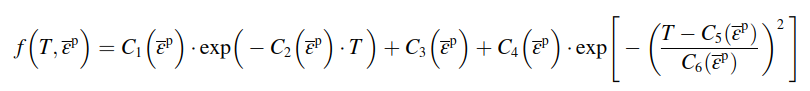

In [101]:
def fit_data_with_6_parameters(file, T, indices, starting_column):
    data = pd.read_csv(f"{file}_ref.csv")
    csv_output_path = f'Parameters_6_{file}.csv'
    
    # Define the function to fit with six parameters
    def f_func(T, C1, C2, C3, C4, C5, C6):
        return C1 * np.exp(-C2 * T) + C3 + C4 * np.exp(-((T - C5) / C6)**2)
    
    # Initialize a list to store fitted parameters for CSV
    fitted_parameters = []
    
    # Loop through specified rows and perform fitting
    for j, i in enumerate(indices):
        if i != 0:
            # Extract stress data from row `i`, starting from the specified starting column to the end
            stress = data.iloc[i, starting_column:].values

            # Adjusted bounds to allow more flexibility in fitting
            bounds = (
                [0, 0.00001, np.min(stress) * 0.5, 0, np.min(T)*0.2, 5],   # Lower bounds
                [np.max(stress) * 2, 0.01, np.max(stress), 10, np.max(T), 500]  # Upper bounds
            )

            # Perform the curve fitting without an initial guess
            try:
                params, _ = curve_fit(f_func, T, stress, bounds=bounds, max_nfev=20000)
            except RuntimeError:
                print(f"Could not fit row {i}")
                continue

            # Collect the parameters for saving in the CSV file
            fitted_parameters.append([data.iloc[i, 0], *params])

            # Generate data for the fit curve
            T_fit = np.linspace(np.min(T), np.max(T), 100)
            stress_fit = f_func(T_fit, *params)

            # Calculate residuals for error estimation
            residuals = stress - f_func(T, *params)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((stress - np.mean(stress))**2)
            r_squared = 1 - (ss_res / ss_tot)

            # Plot the original data and the fitted curve
            plt.figure()
            plt.plot(T, stress, 'o', label='Data')
            plt.plot(T_fit, stress_fit, '-', label='Fit')
            plt.xlabel('Temperature (K)')
            plt.ylabel('Stress')
            plt.title(f"Fit for Row {i} (R² = {r_squared:.3f})")
            plt.legend([
                f'PEEQ={data.iloc[i, 0]:.5f}\n'
                f'Fit: C1={params[0]:.3f}, C2={params[1]:.3f}, C3={params[2]:.3f},\n'
                f'C4={params[3]:.3f}, C5={params[4]:.3f}, C6={params[5]:.3f}'
            ])
            plt.show()

    # Save the parameters to a CSV file
    columns = ['PEEQ', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
    fitted_parameters_df = pd.DataFrame(fitted_parameters, columns=columns)
    fitted_parameters_df.to_csv(csv_output_path, index=False)
    print(f"Fitted parameters saved to '{csv_output_path}'")


In [102]:
file_0001 = 'Fitted_FC_TmpDpn_RD_StrRt0.01'
T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
#T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
#indices = np.arange(1, 306)
starting_column = 6 #other strain-rates
#starting_column = 8 #0.0001

/opt/software/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


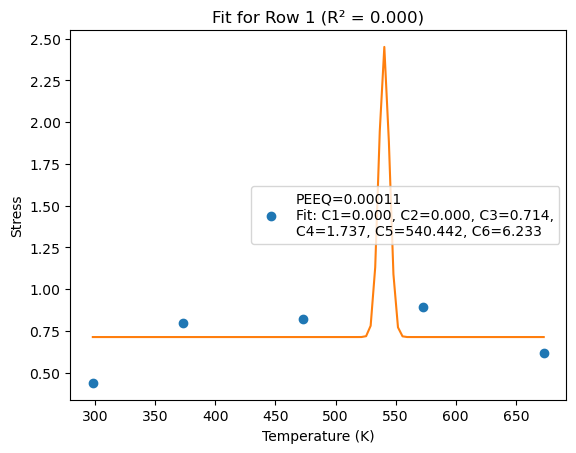

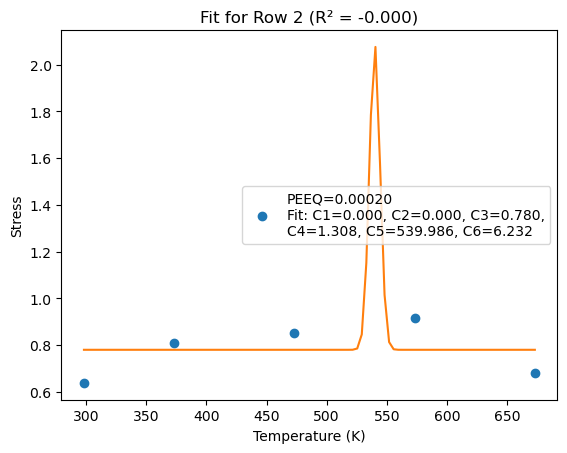

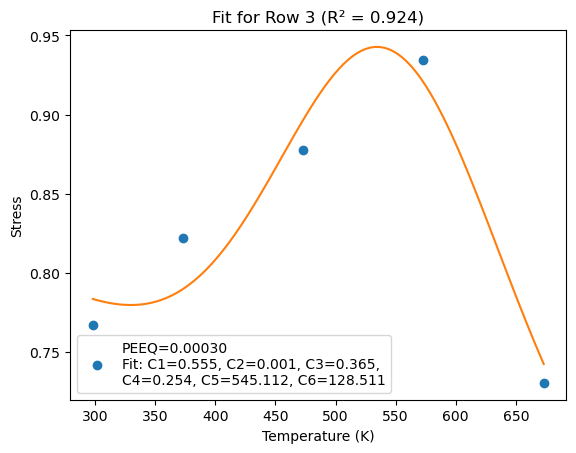

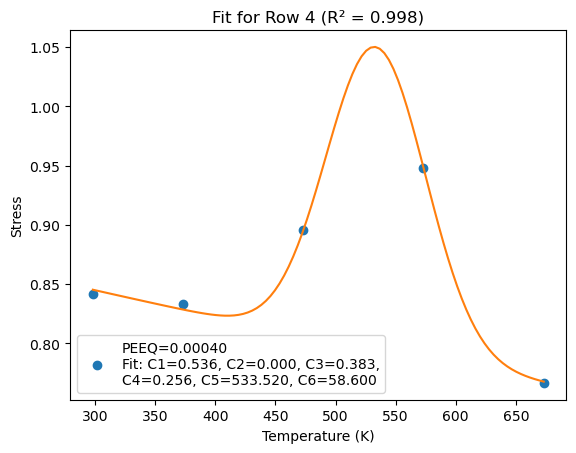

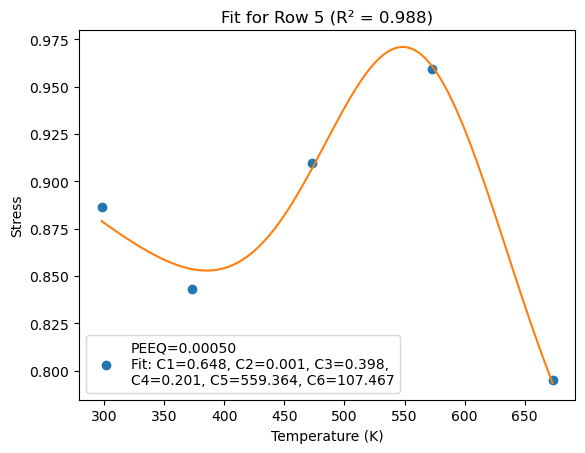

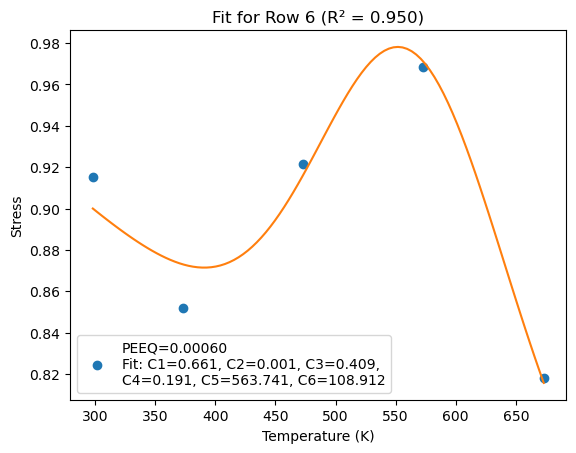

Could not fit row 10


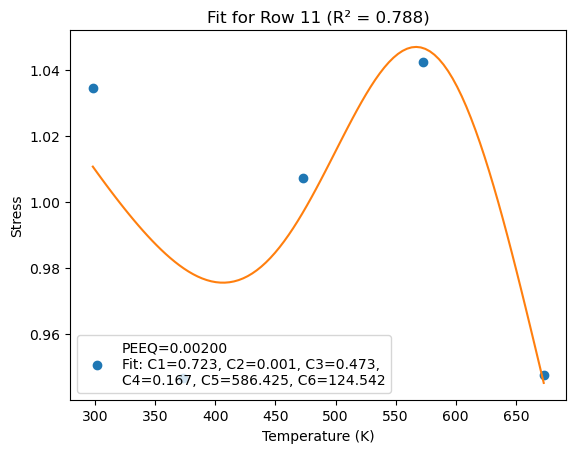

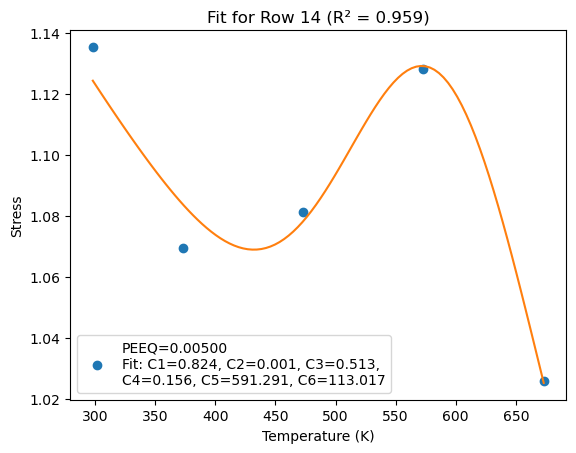

Could not fit row 15


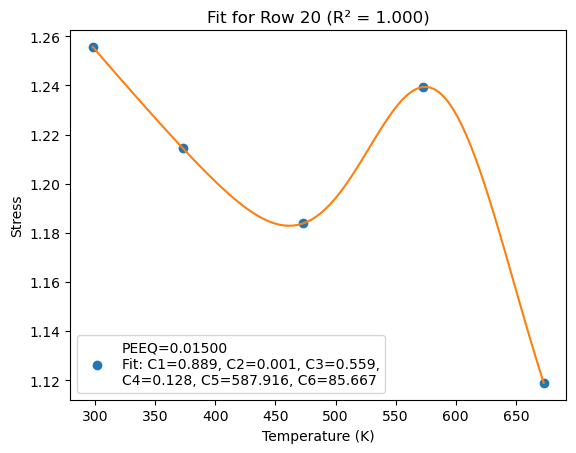

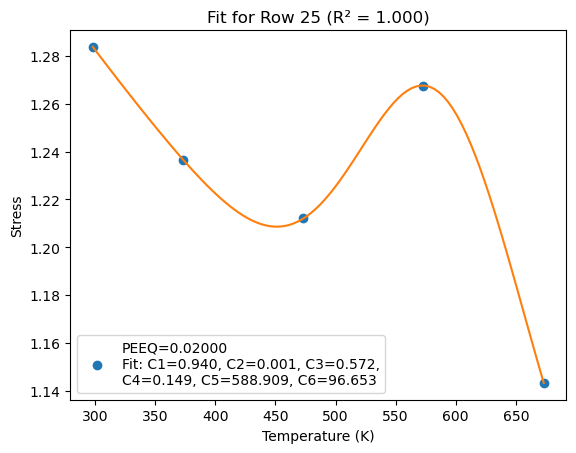

Could not fit row 30


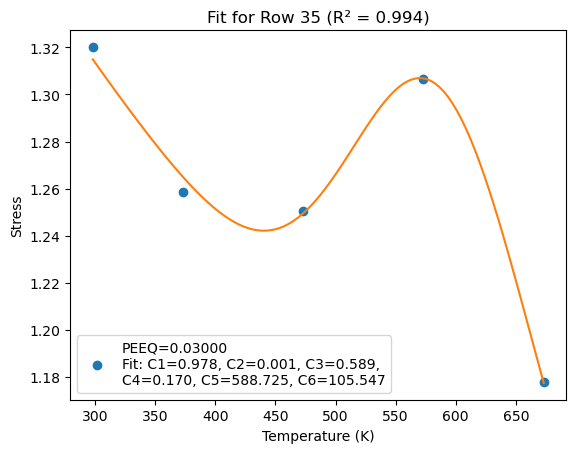

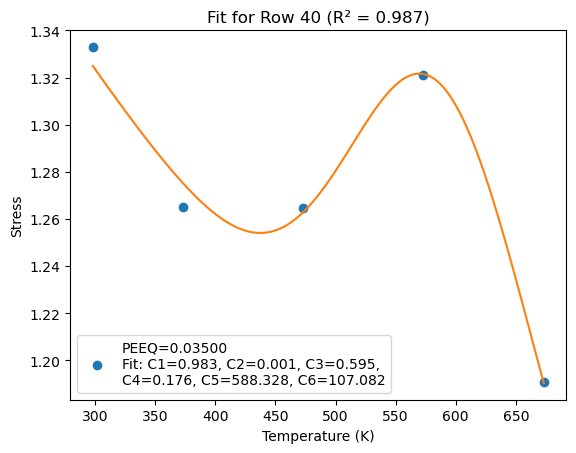

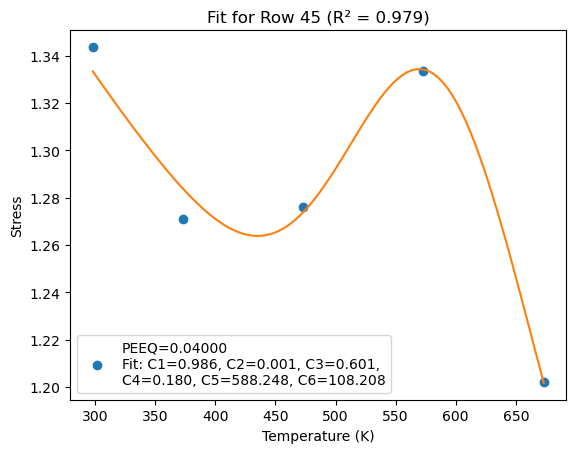

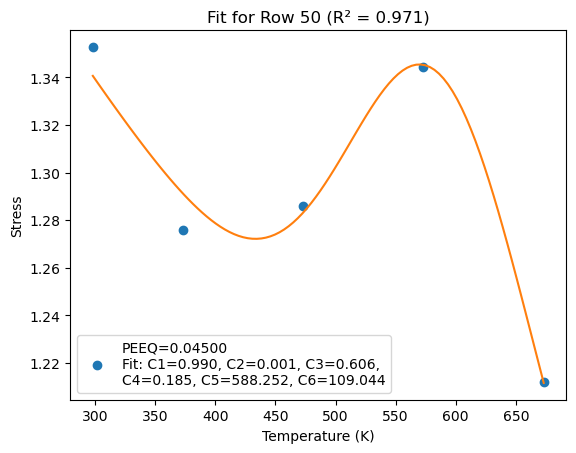

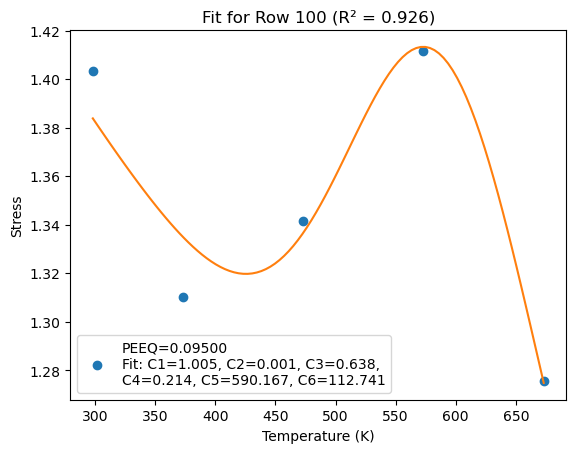

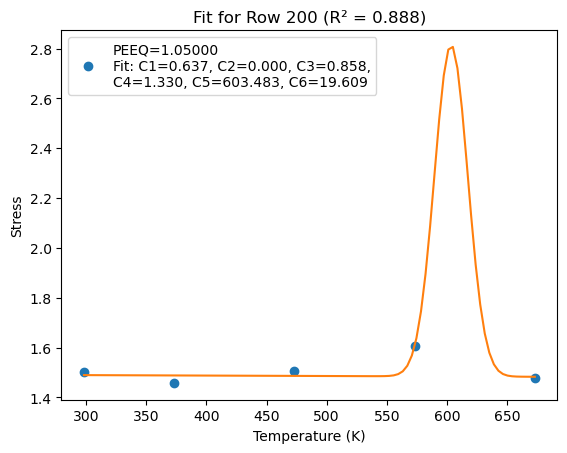

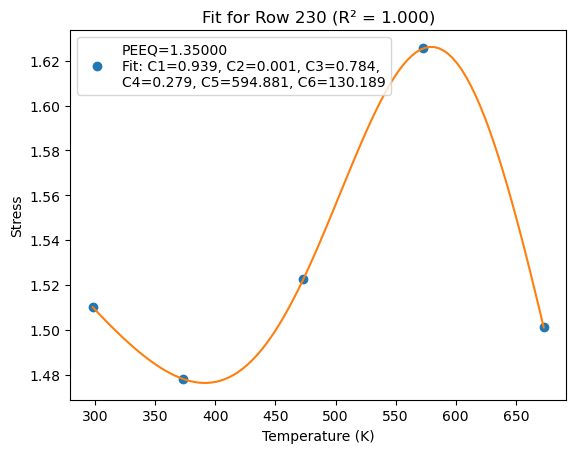

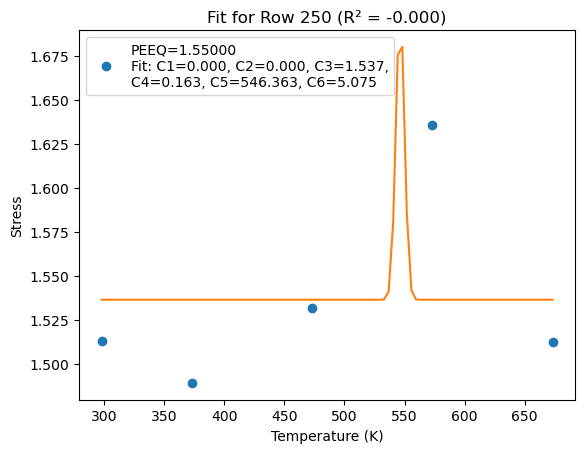

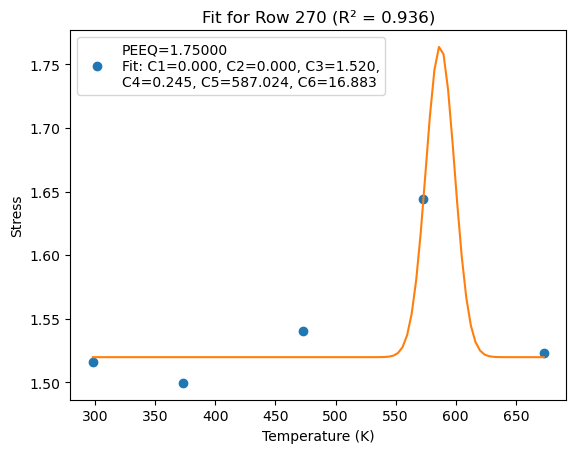

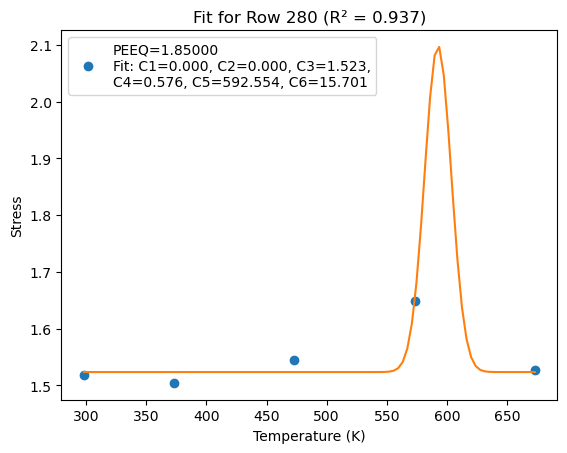

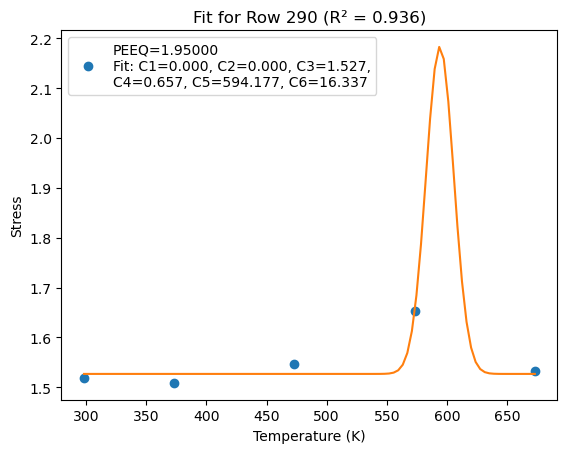

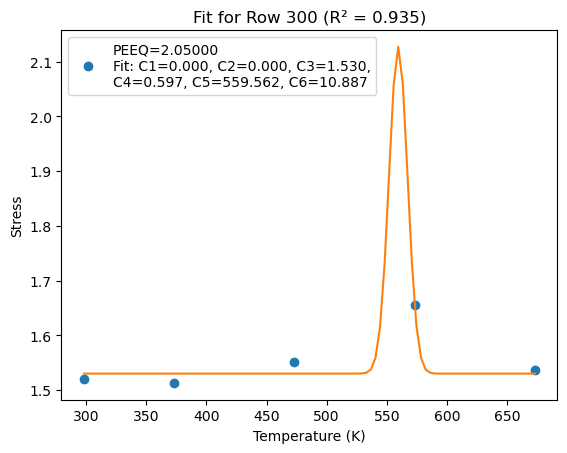

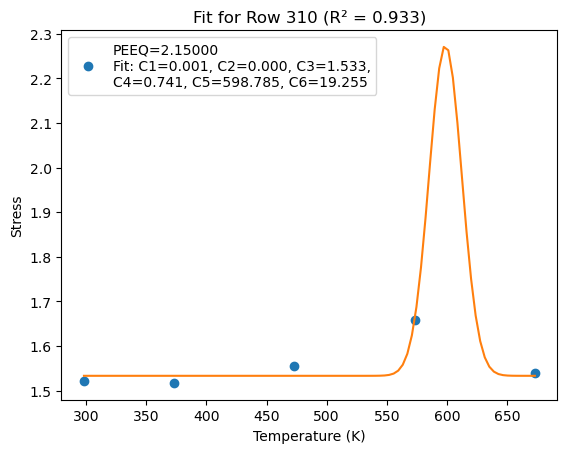

Fitted parameters saved to 'Parameters_6_Fitted_FC_TmpDpn_RD_StrRt0.01.csv'


In [103]:
fit_data_with_6_parameters(file_0001, T, indices, starting_column)

## 6 paprameters - with initial guess

In [108]:
# Load the CSV file
data = pd.read_csv('Fitted_FC_TmpDpn_RD_StrRt0.01_ref.csv')

r_squared <0.9 at PEEQ = 0.00011


/opt/software/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


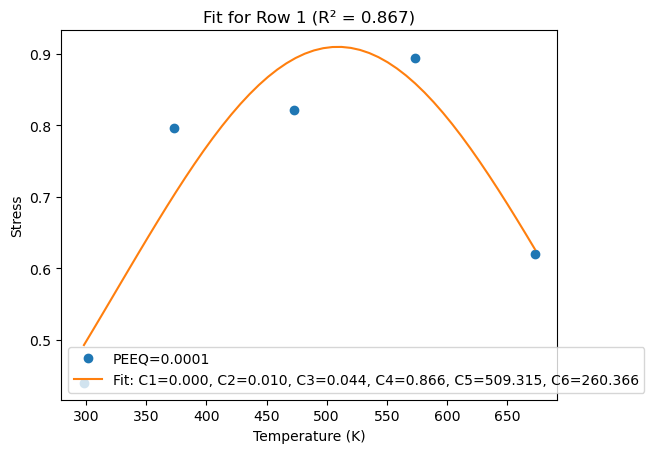

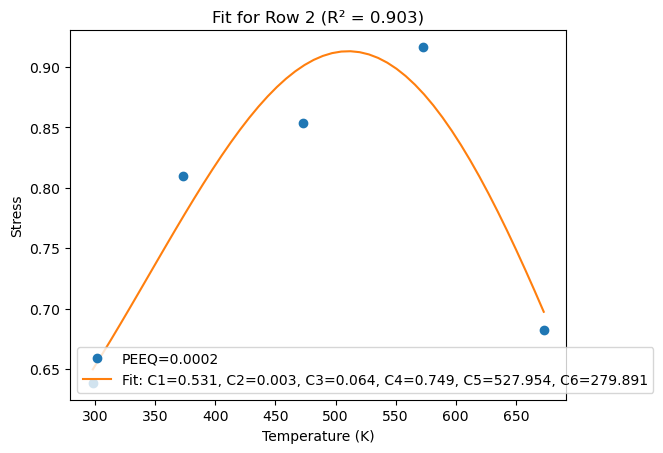

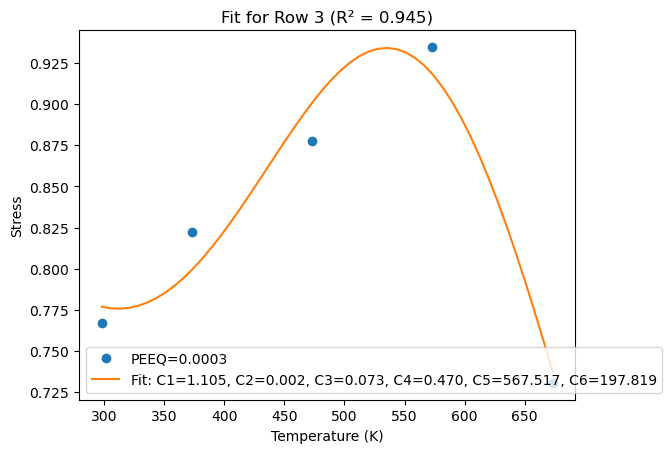

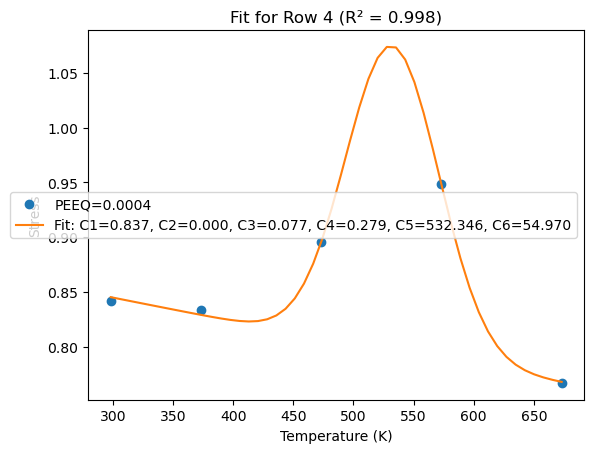

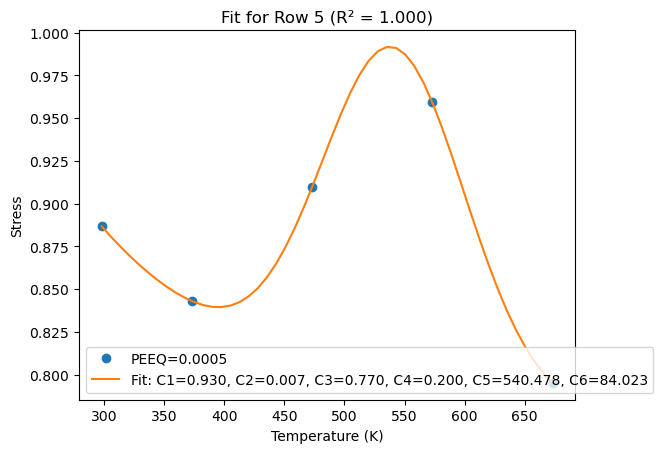

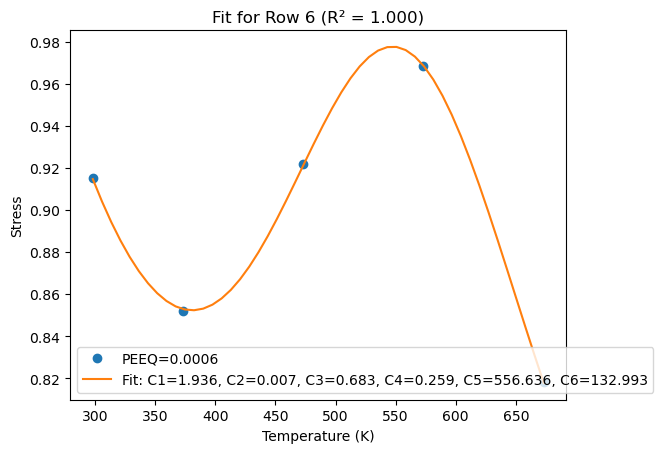

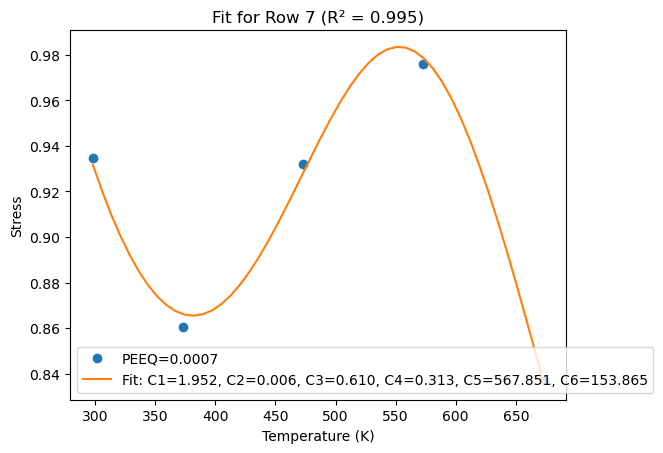

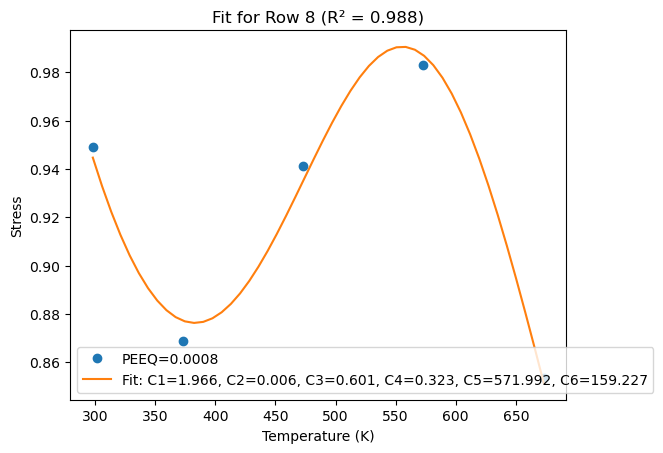

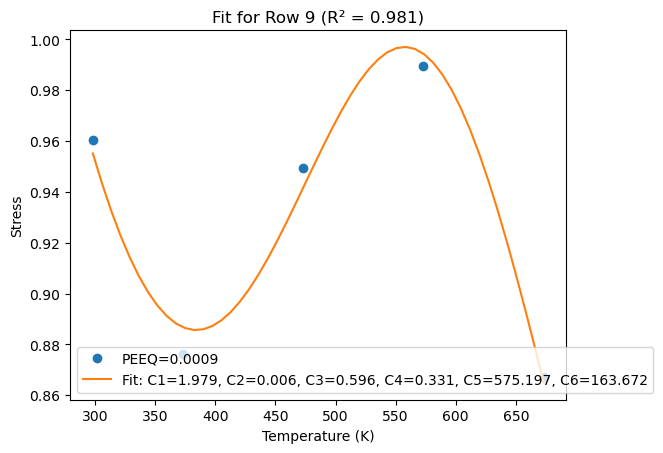

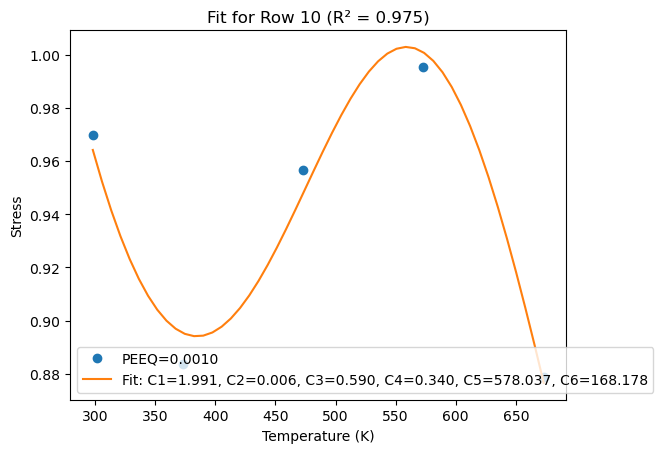

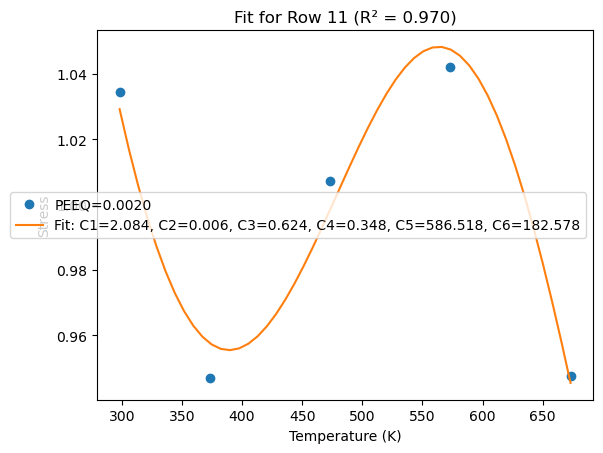

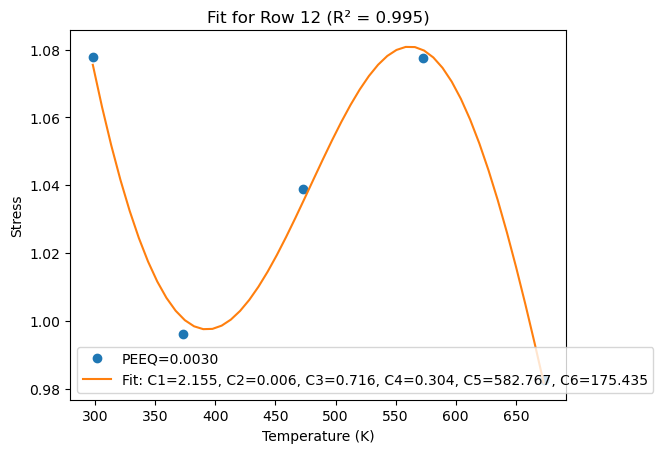

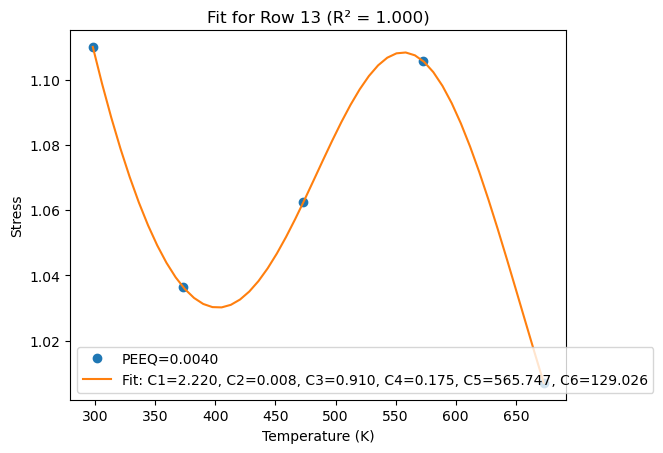

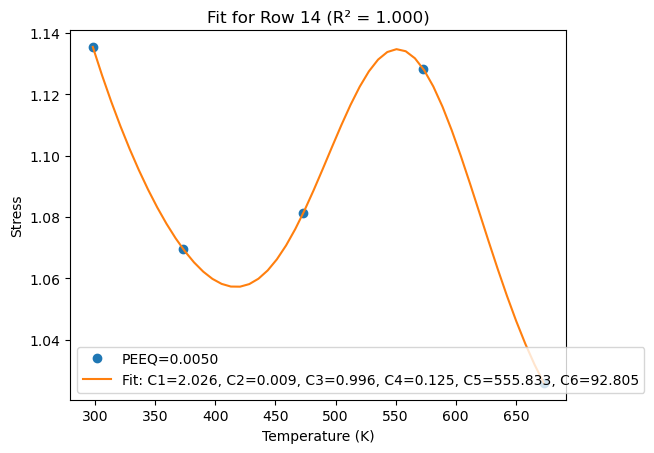

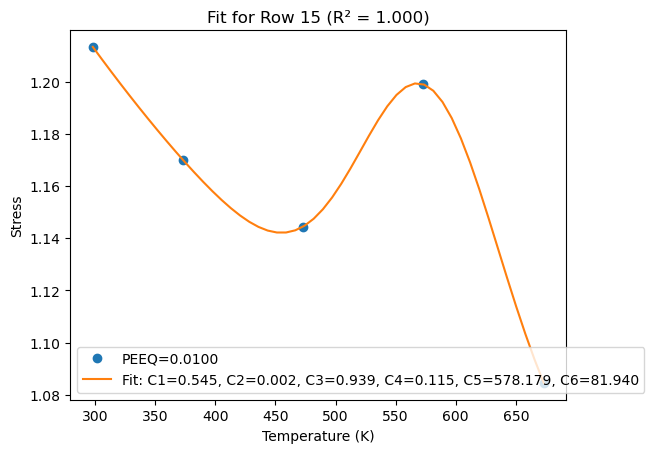

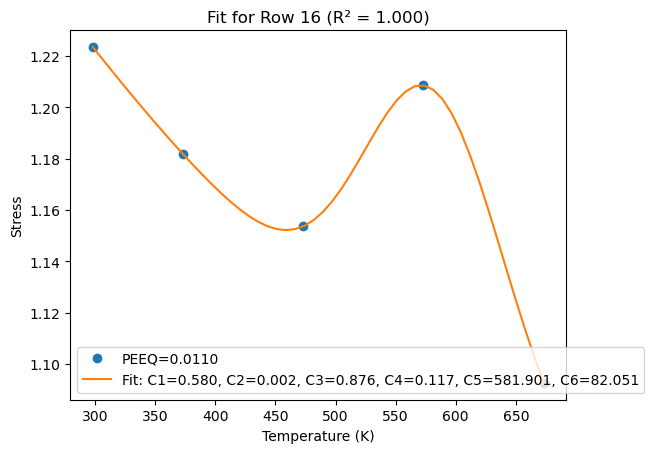

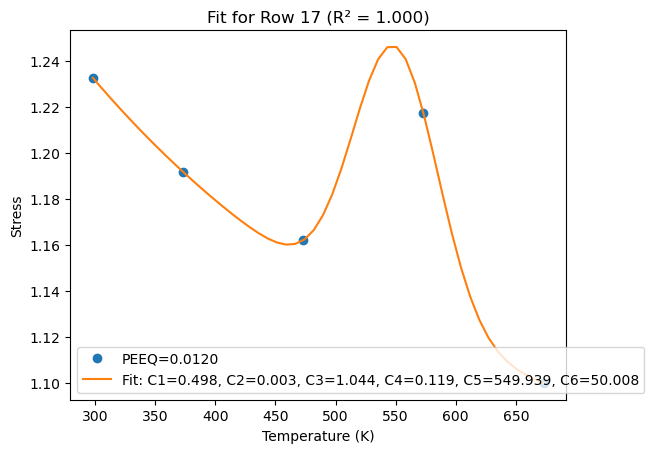

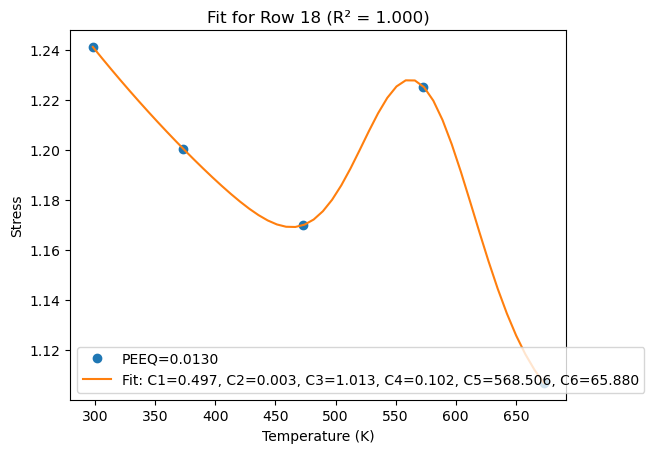

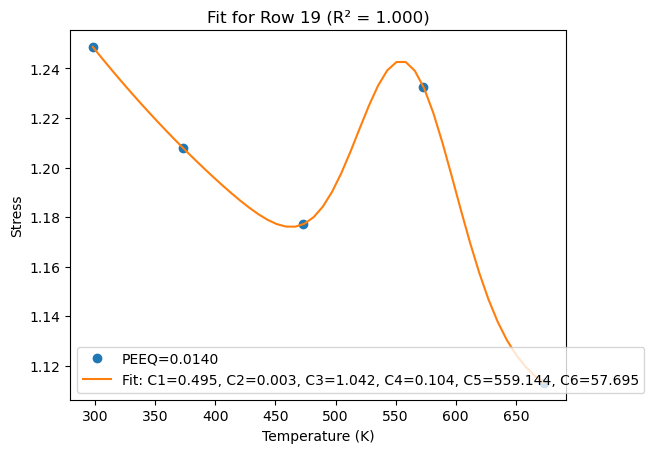

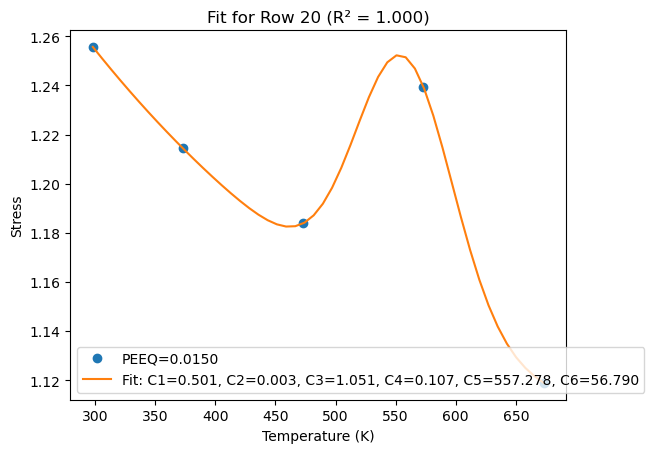

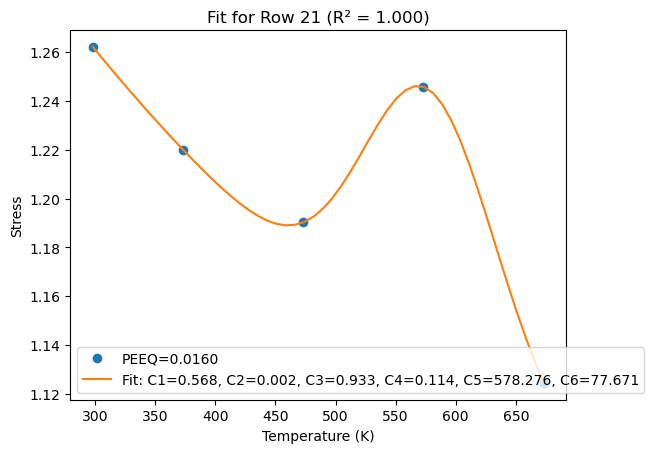

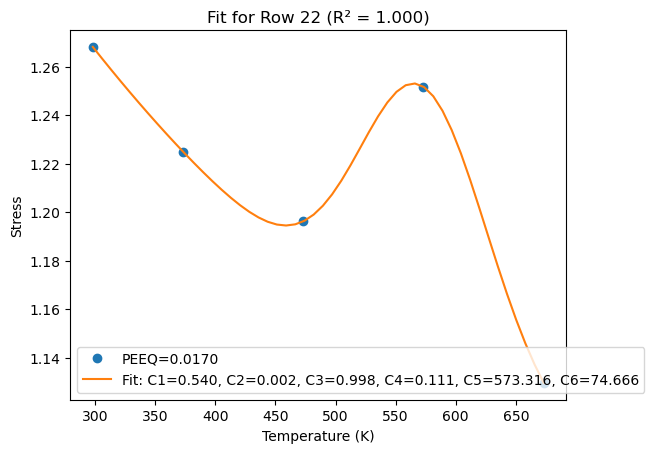

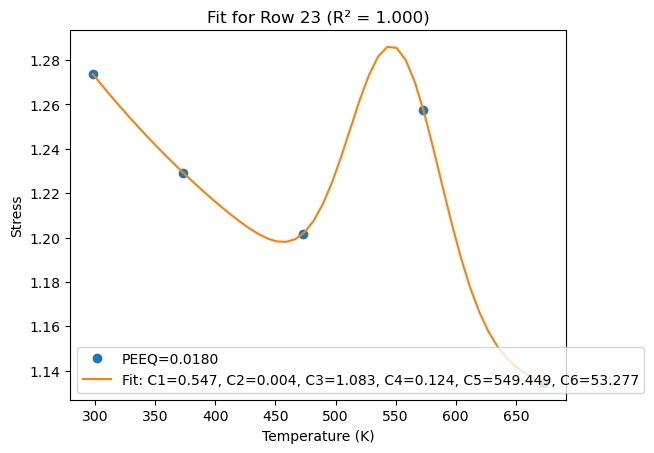

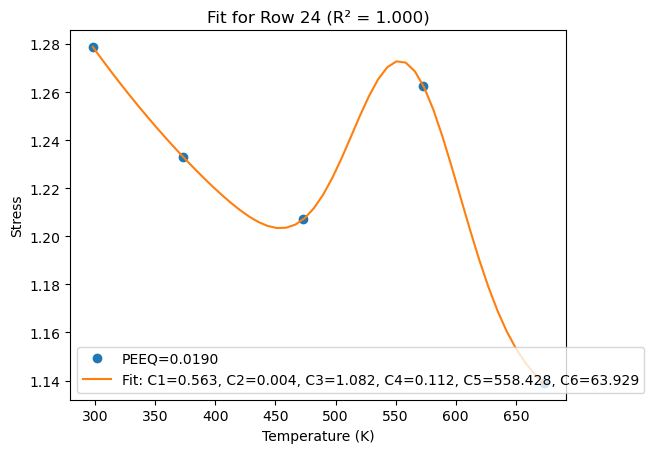

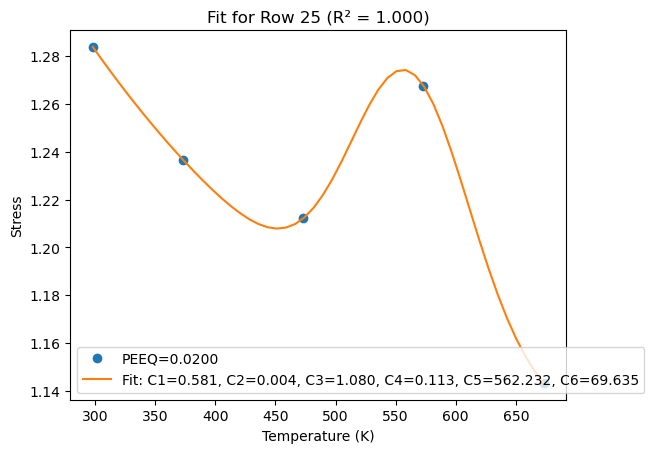

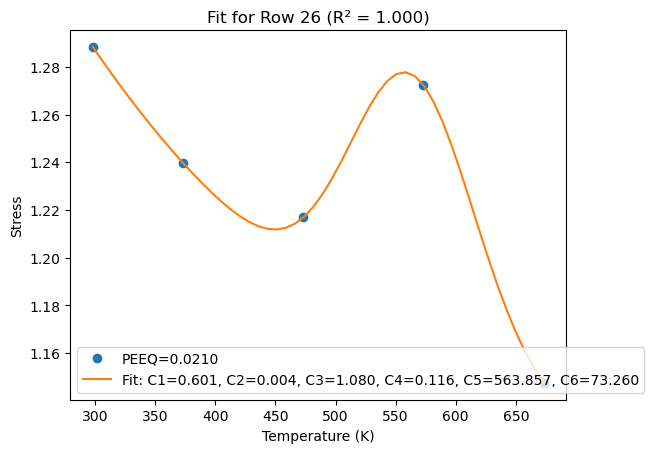

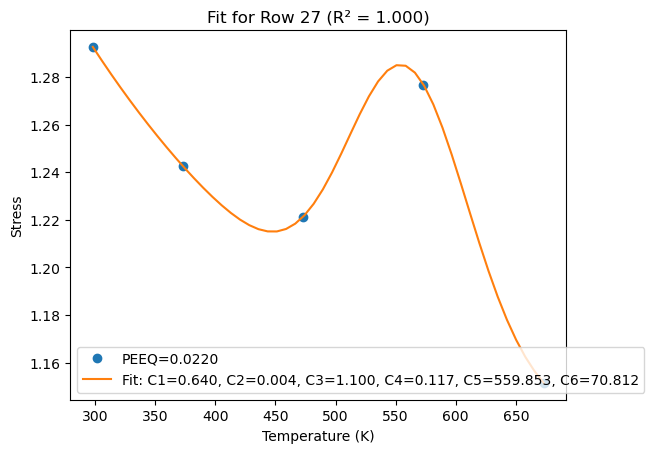

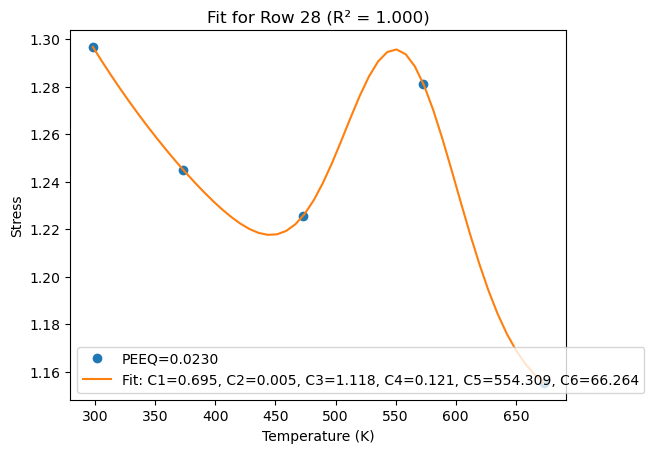

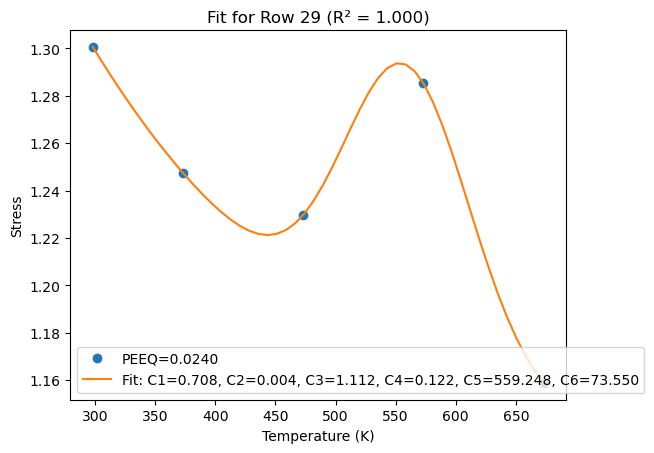

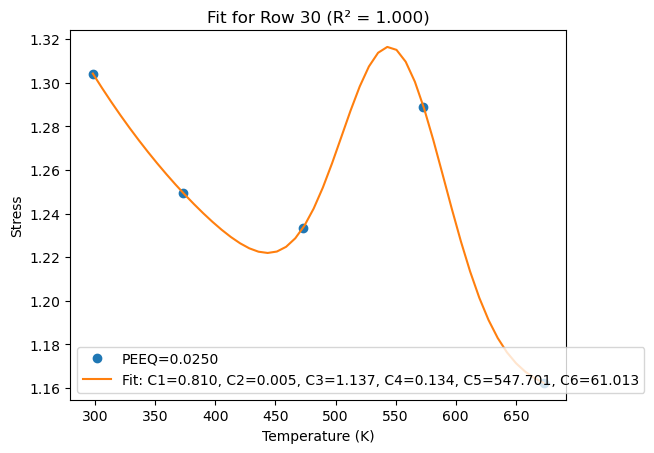

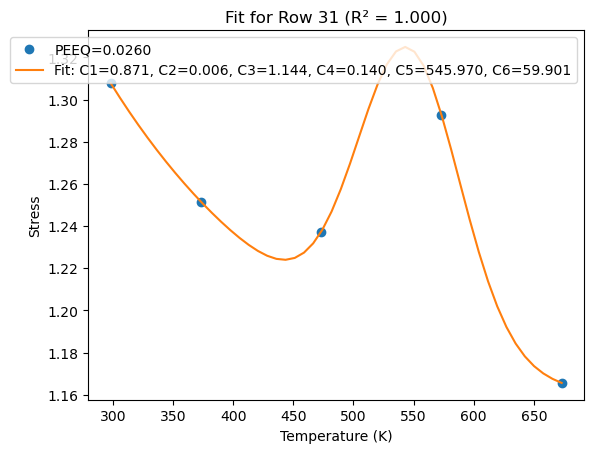

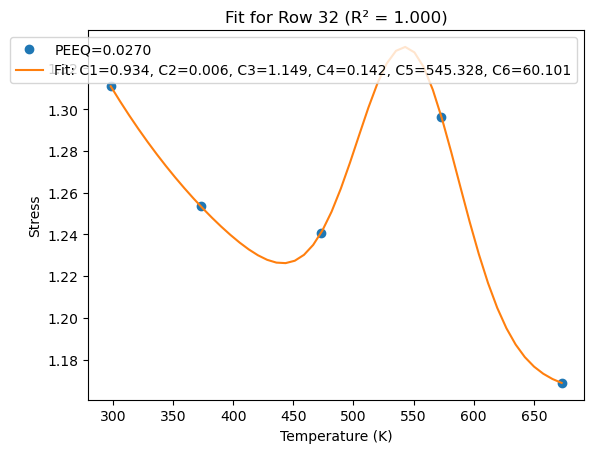

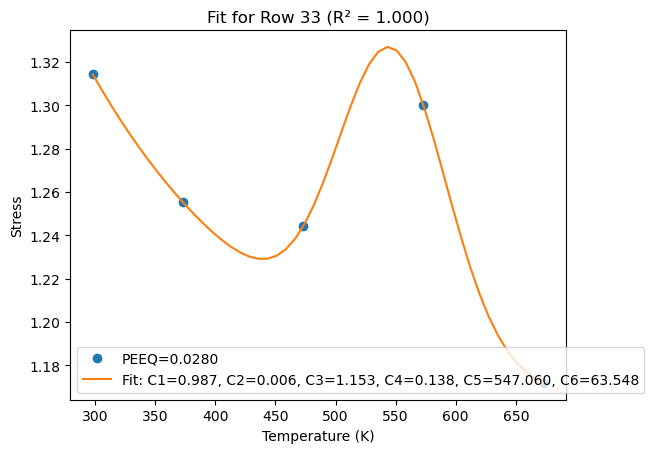

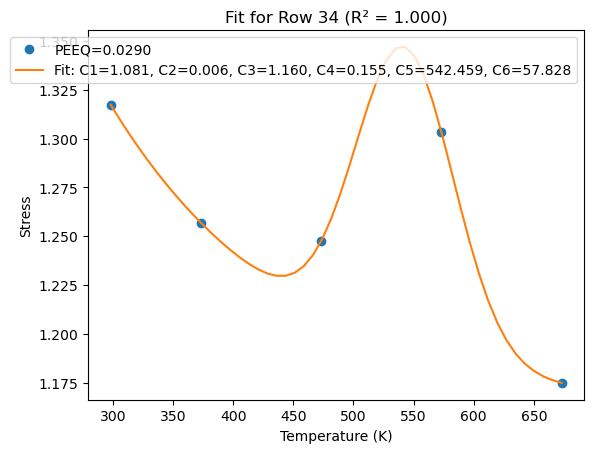

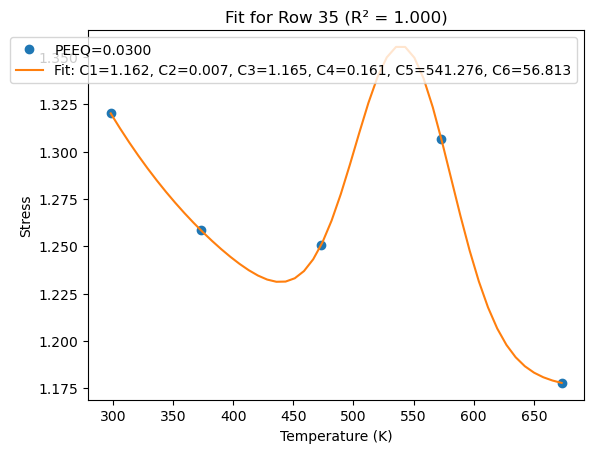

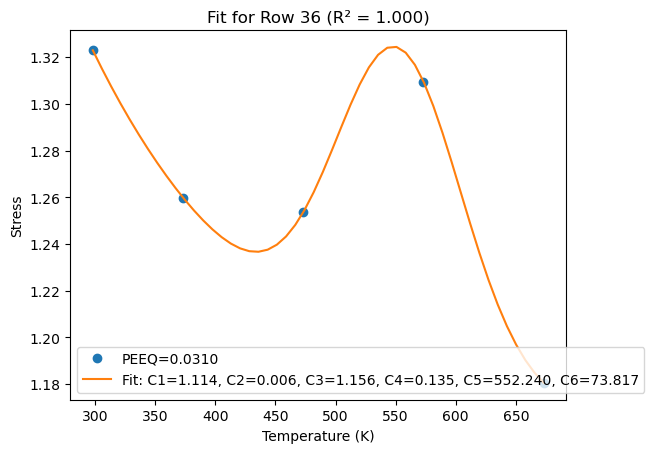

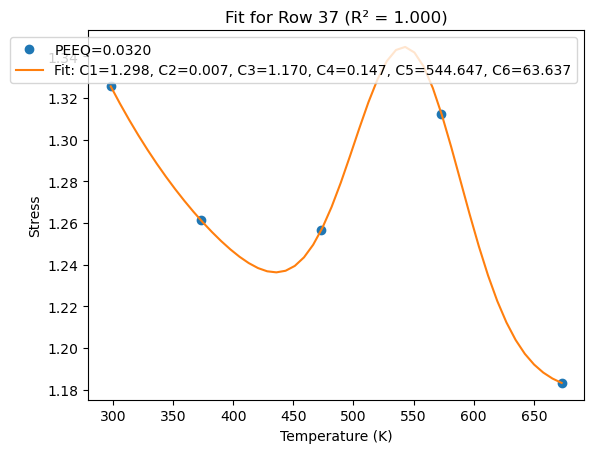

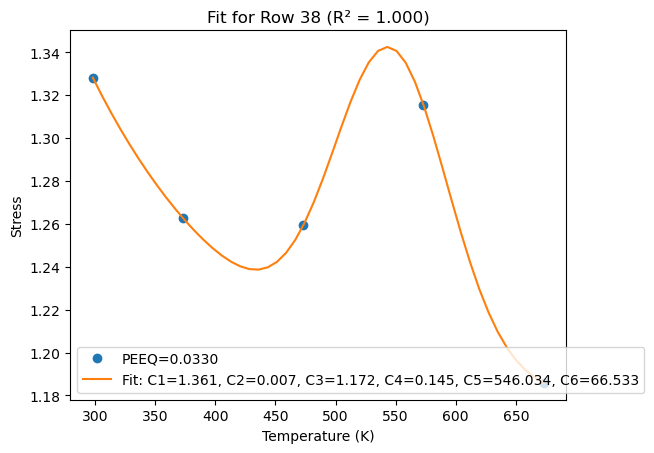

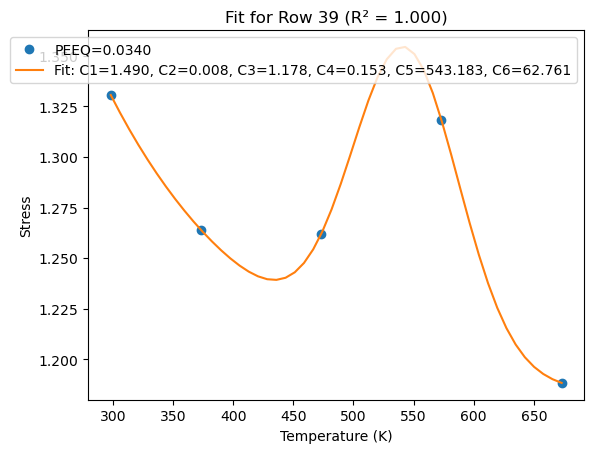

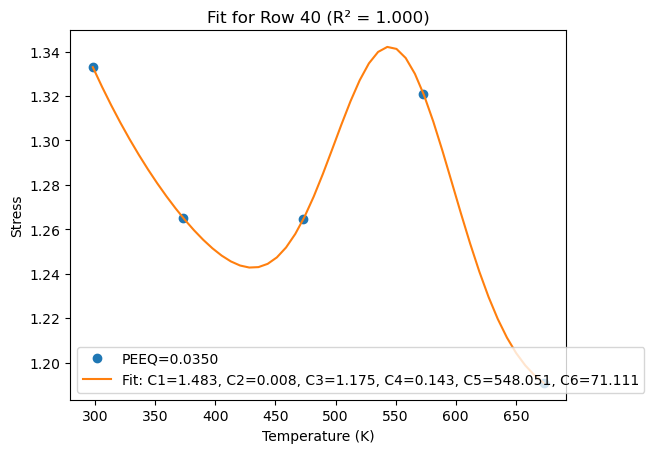

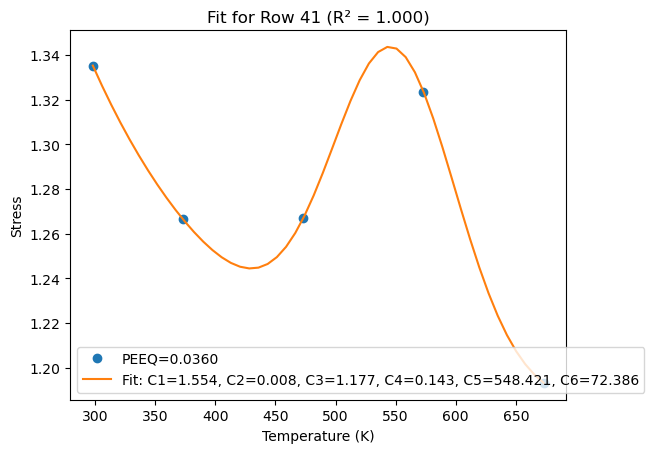

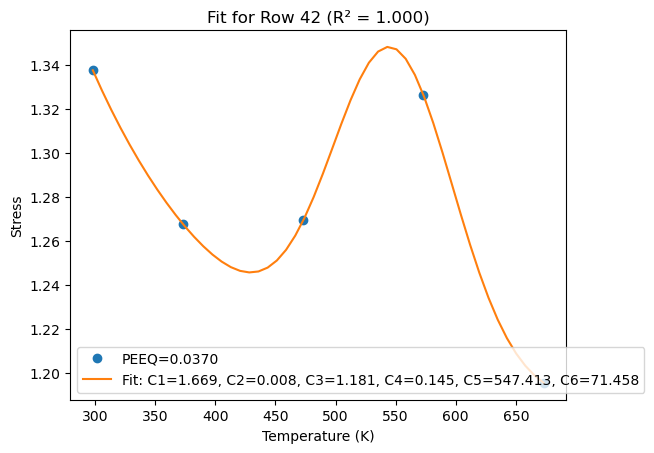

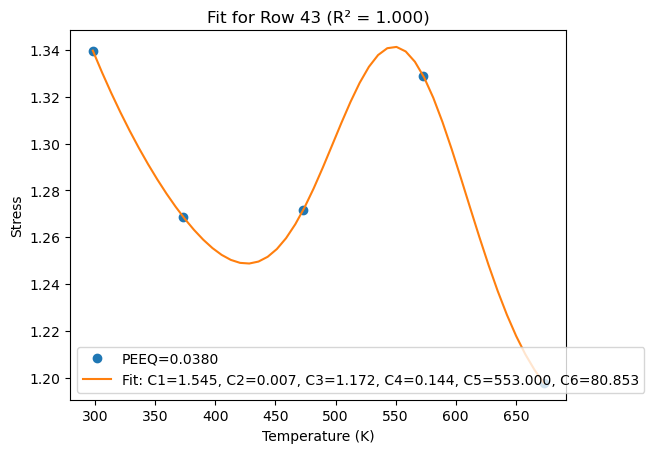

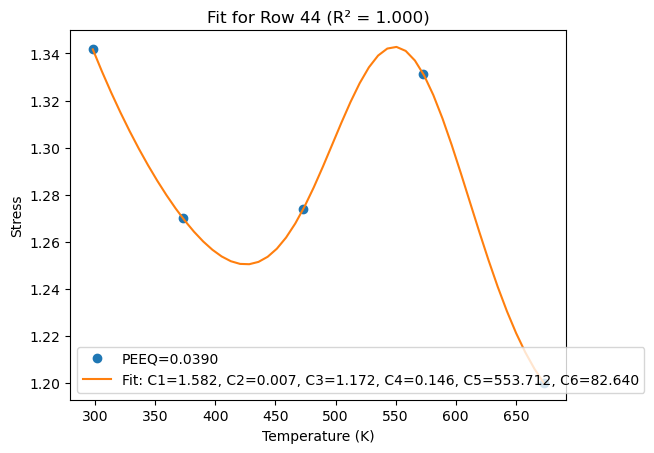

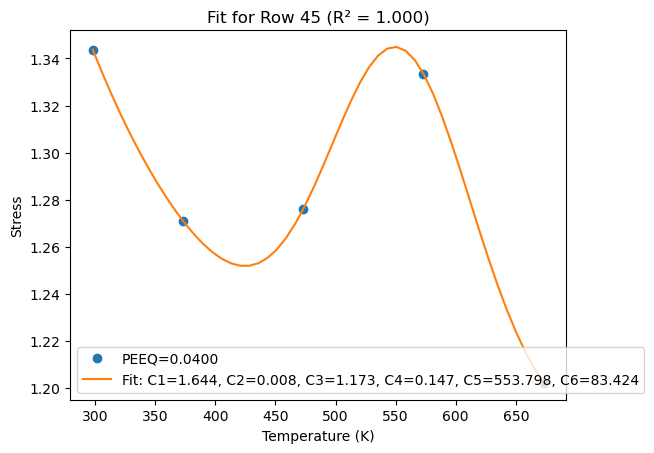

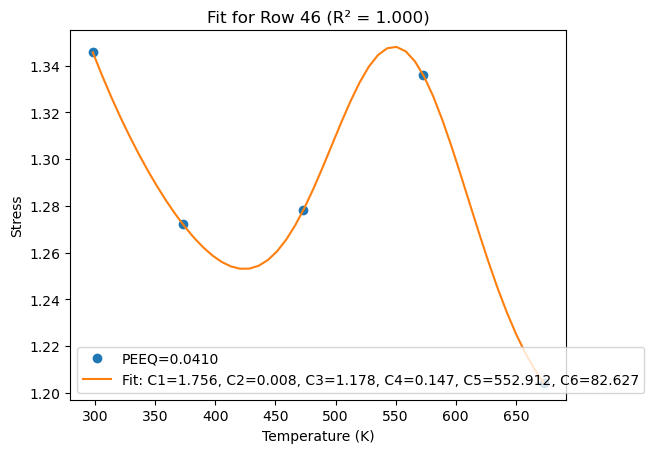

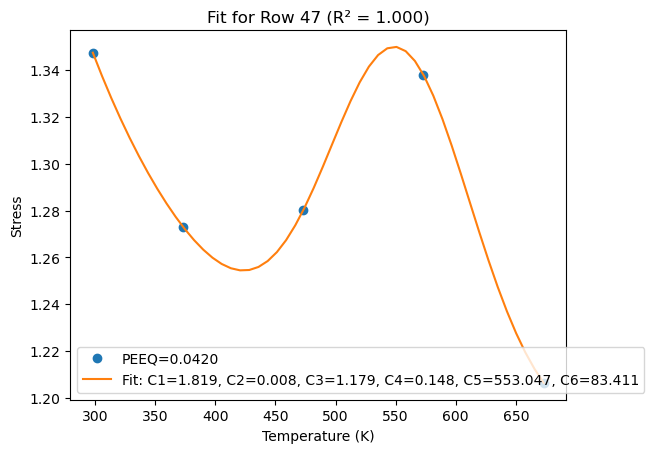

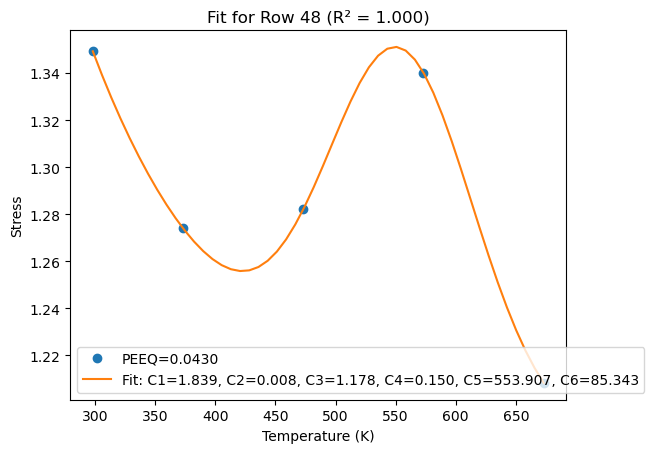

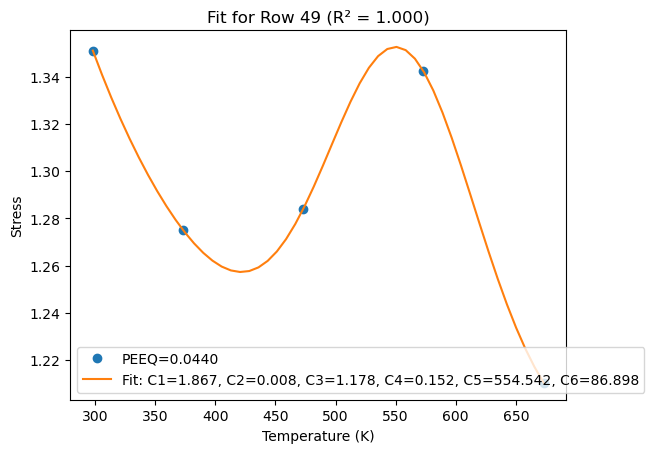

In [109]:
#T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15])

T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
#T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001

starting_column = 6 #other strain-rates
#starting_column = 8 #0.0001


# Define the function to fit
def f_func(T, C1, C2, C3, C4, C5, C6):
    return C1 * np.exp(-C2 * T) + C3 + C4 * np.exp(-((T - C5) / C6)**2)

# List of indices for the rows to process
#indices = np.array([3, 4, 5, 6, 11])

indices = np.arange(1,50)
#indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
# Dictionary to store fitted parameters
p = {}

# Loop through specified rows and perform fitting
for j, i in enumerate(indices):
    if i != 0:
        # Extract stress data from row `i`, starting from the 9th column to the end
        stress = data.iloc[i, starting_column:].values
        
        # Provide initial guesses and bounds
        #initial_guess = [1, 0.001, 0.5, 1, 300, 100]
        #bounds = ([0, 0.0001, 0, 0, 0, 100], [5., 0.003, 3.0, 10, 600, 500])
        #initial_guess = [1, 0.002, np.mean(stress), 1.0, np.mean(T), 100]
        #bounds = (
                #[0, 0.00001, np.min(stress) * 0.7, 0, np.min(T), 50],  # Lower bounds for six parameters
                #[np.max(stress) * 2, 0.01, np.max(stress), 5, np.max(T), 300]  # Upper bounds for six parameters
           # )
        initial_guess = [1.0, 0.005, np.mean(stress), 0.8, np.mean(T), 120]
        bounds = (
            [0, 0.000001, np.min(stress) * 0.1, 0, np.min(T)* 0.1, 50],  # Lower bounds
            [np.max(stress) * 2, 0.01, np.max(stress), 5, np.max(T), 300]  # Upper bounds
        )
        
        # Perform the curve fitting
        try:
            params, _ = curve_fit(f_func, T, stress, p0=initial_guess, bounds=bounds, max_nfev=10000)
        except RuntimeError:
            print(f"Could not fit row {i}")
            continue
        
        # Store the fitted parameters for this row
        p[f"fit{i}"] = params
        
        # Generate data for the fit curve
        T_fit = np.linspace(np.min(T), np.max(T), 50)
        stress_fit = f_func(T_fit, *params)
        
        # Calculate residuals for error estimation
        residuals = stress - f_func(T, *params)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((stress - np.mean(stress))**2)
        r_squared = 1 - (ss_res / ss_tot)
        if r_squared <0.9:
            print(f'r_squared <0.9 at PEEQ = {data.iloc[i, 0]:.5f}')
        # Plot the original data and the fitted curve
        plt.plot(T, stress, 'o', label='Data')
        plt.plot(T_fit, stress_fit, '-', label='Fit')
        plt.xlabel('Temperature (K)')
        plt.ylabel('Stress')
        plt.title(f"Fit for Row {i} (R² = {r_squared:.3f})")
        plt.legend([f'PEEQ={data.iloc[i, 0]:.4f}', f'Fit: C1={params[0]:.3f}, C2={params[1]:.3f}, C3={params[2]:.3f}, C4={params[3]:.3f}, C5={params[4]:.3f}, C6={params[5]:.3f}'])
        plt.show()

## 9 paprameters - without initial guess

In [43]:
def fit_data_with_9_parameters(file, T, indices, starting_column):
    data = pd.read_csv(f"{file}_ref.csv")
    csv_output_path = f'Parameters_6_{file}.csv'
    # Define the function to fit
    def f_func(T, C1, C2, C3, C4, C5, C6, C7, C8, C9):
        return (C1 * np.exp(-C2 * T) + C3 +
                C4 * np.exp(-((T - C5) / C6)**2) +
                C7 * np.exp(-((T - C8) / C9)**2))
    
    # Initialize a dictionary to store fitted parameters and a list to collect data for the CSV
    fitted_parameters = []
    
    # Loop through specified rows and perform fitting
    for j, i in enumerate(indices):
        if i != 0:
            # Extract stress data from row `i`, starting from the specified starting column to the end
            stress = data.iloc[i, starting_column:].values

            # Set adaptive bounds based on the input data characteristics
            # Set adaptive bounds based on the input data characteristics
            bounds = (
                [0, 0.00001, np.min(stress) * 0.5, 0, np.min(T), 10, 0, np.min(T), 10],  # Lower bounds
                [np.max(stress) * 2, 0.01, np.max(stress), 10, np.max(T), 200, np.max(stress), np.max(T), 200]  # Upper bounds
            )

            # Perform the curve fitting without an initial guess
            try:
                params, _ = curve_fit(f_func, T, stress, bounds=bounds, max_nfev=10000)
            except RuntimeError:
                print(f"Could not fit row {i}")
                continue

            # Collect the parameters for saving in the CSV file
            fitted_parameters.append([data.iloc[i, 0], *params])

            # Generate data for the fit curve
            T_fit = np.linspace(np.min(T), np.max(T), 100)
            stress_fit = f_func(T_fit, *params)

            # Calculate residuals for error estimation
            residuals = stress - f_func(T, *params)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((stress - np.mean(stress))**2)
            r_squared = 1 - (ss_res / ss_tot)

            # Plot the original data and the fitted curve
            plt.figure()
            plt.plot(T, stress, 'o', label='Data')
            plt.plot(T_fit, stress_fit, '-', label='Fit')
            plt.xlabel('Temperature (K)')
            plt.ylabel('Stress')
            plt.title(f"Fit for Row {i} (R² = {r_squared:.3f})")
            plt.legend([
                f'PEEQ={data.iloc[i, 0]:.5f}\n'
                f'Fit: C1={params[0]:.3f}, C2={params[1]:.3f}, C3={params[2]:.3f},\n'
                f'C4={params[3]:.3f}, C5={params[4]:.3f}, C6={params[5]:.3f},\n'
                f'C7={params[6]:.3f}, C8={params[7]:.3f}, C9={params[8]:.3f}'
            ])

            # Save the current figure to the PDF
           

    # Save the parameters to a CSV file
    columns = ['PEEQ', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    fitted_parameters_df = pd.DataFrame(fitted_parameters, columns=columns)
    fitted_parameters_df.to_csv(csv_output_path, index=False)
    print(f"Fitted parameters saved to '{csv_output_path}'")


In [44]:
file_0001 = 'Fitted_FC_TmpDpn_RD_StrRt0.0001'
#T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
#indices = np.arange(1, 306)
#starting_column = 6 #other strain-rates
starting_column = 8 #0.0001

/opt/software/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Could not fit row 200


/tmp/ipykernel_326/3514830840.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Fitted parameters saved to 'Parameters_6_Fitted_FC_TmpDpn_RD_StrRt0.0001.csv'


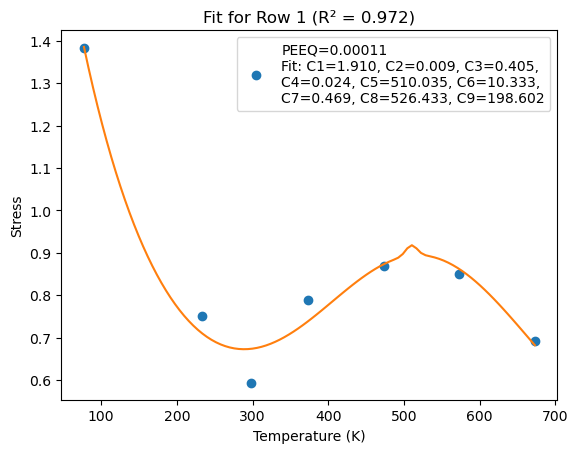

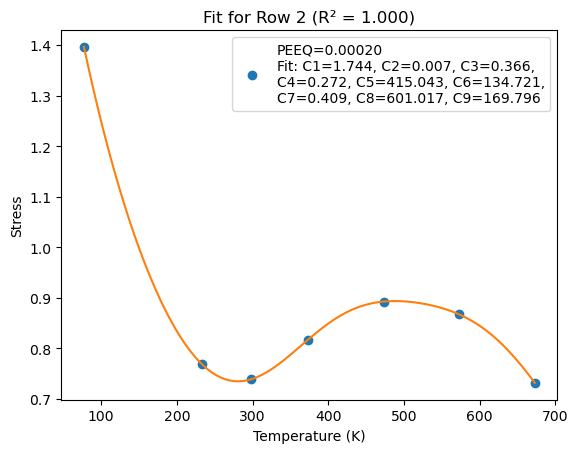

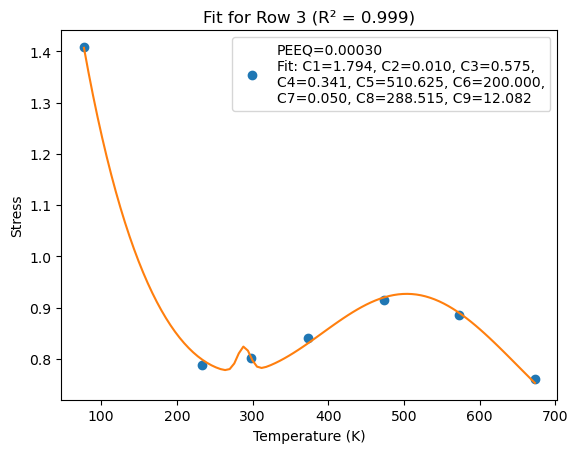

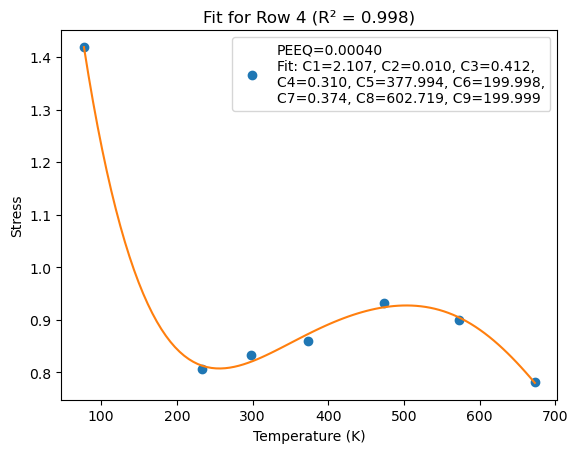

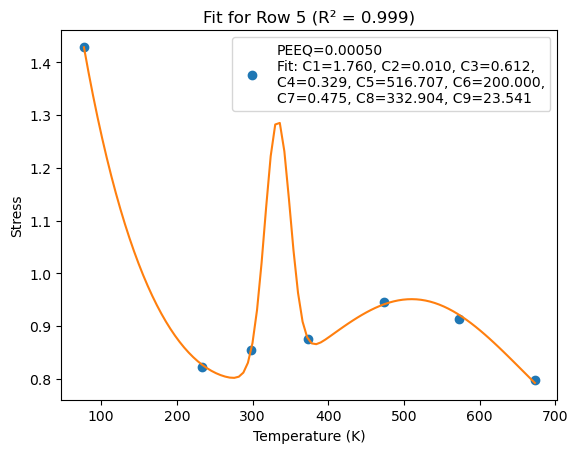

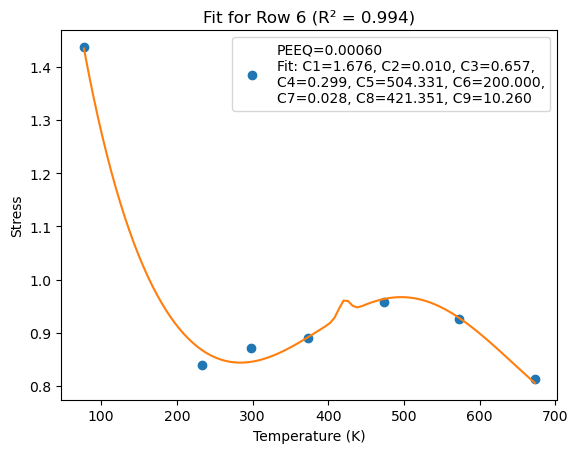

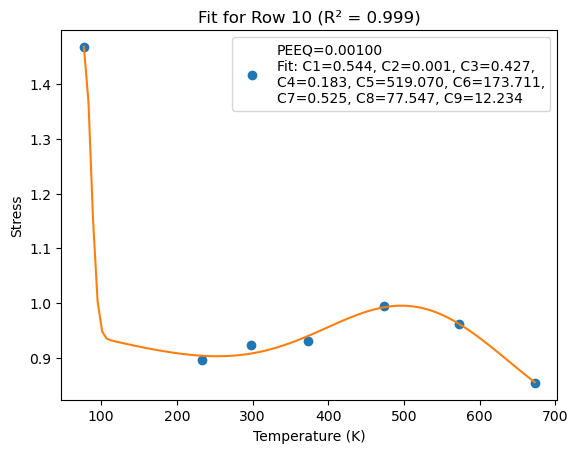

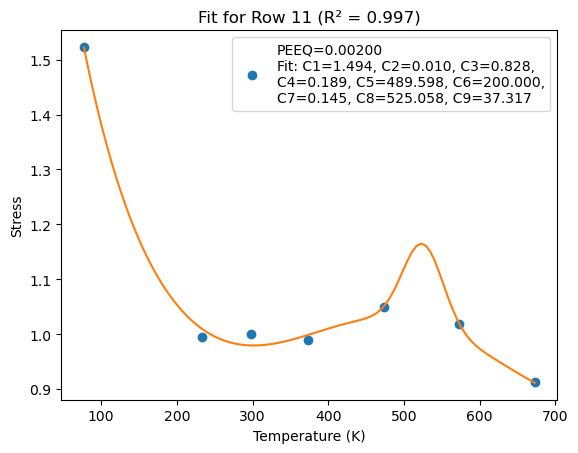

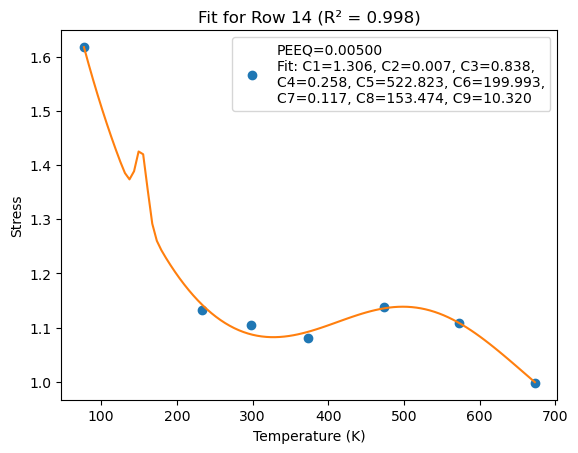

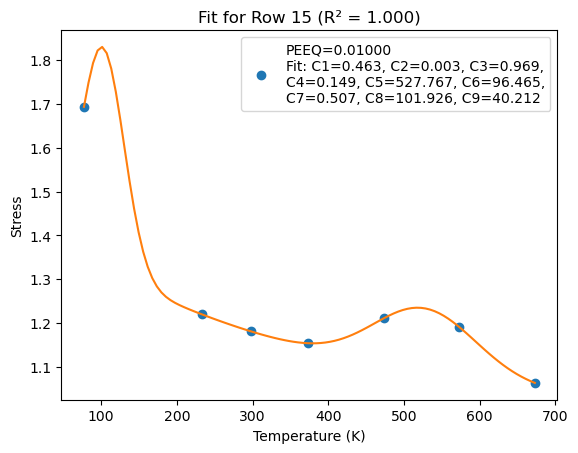

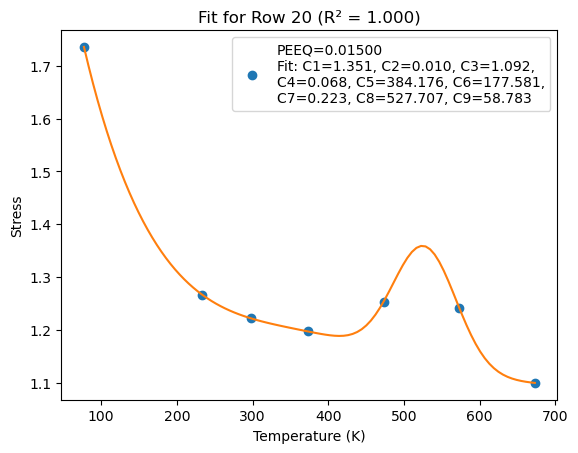

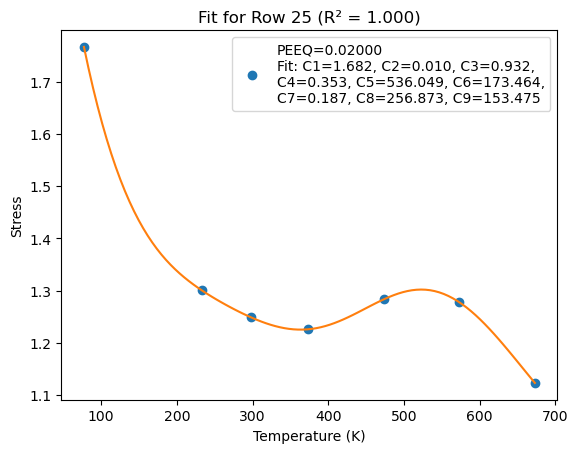

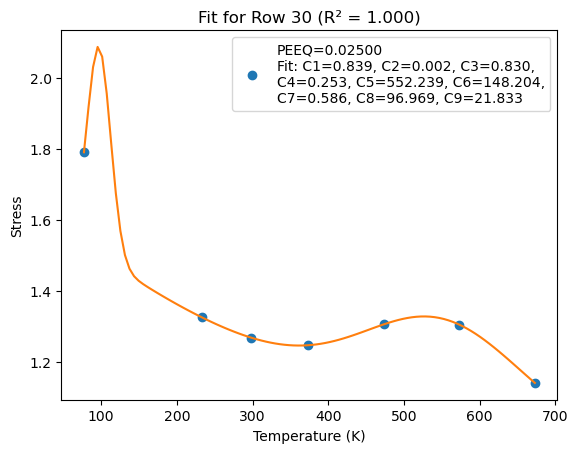

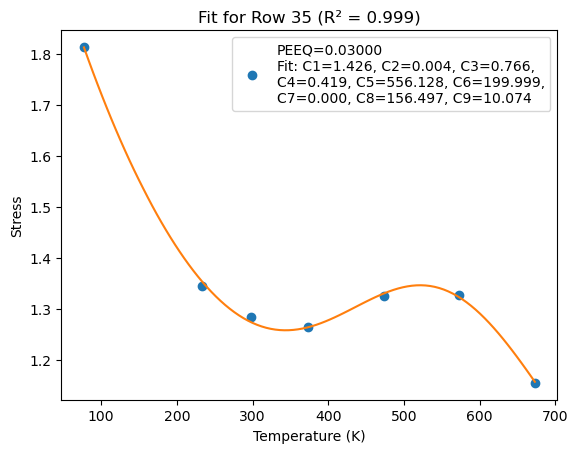

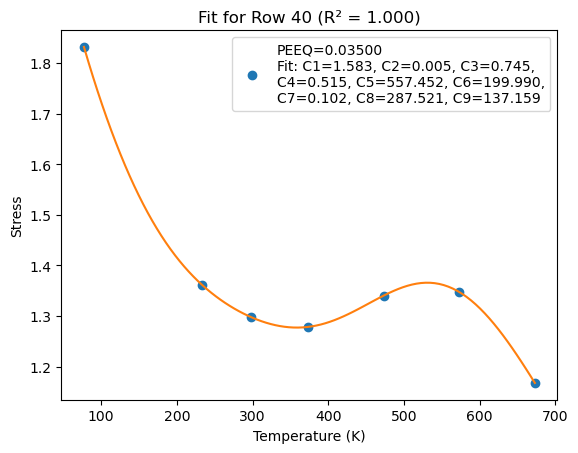

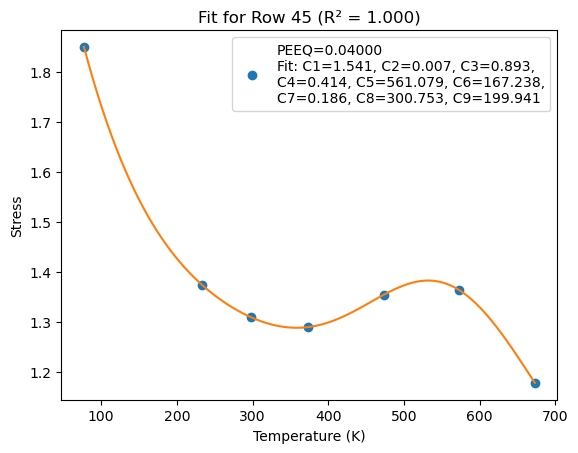

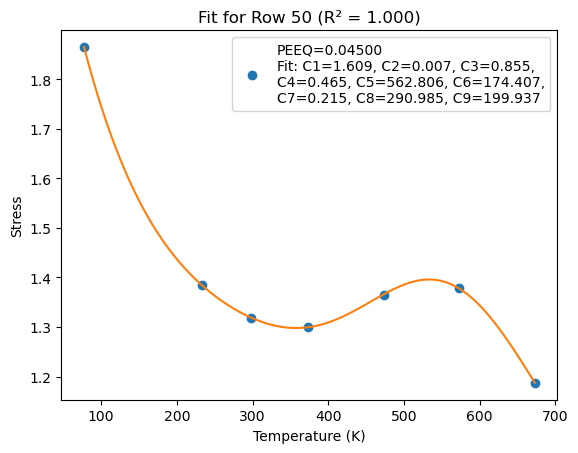

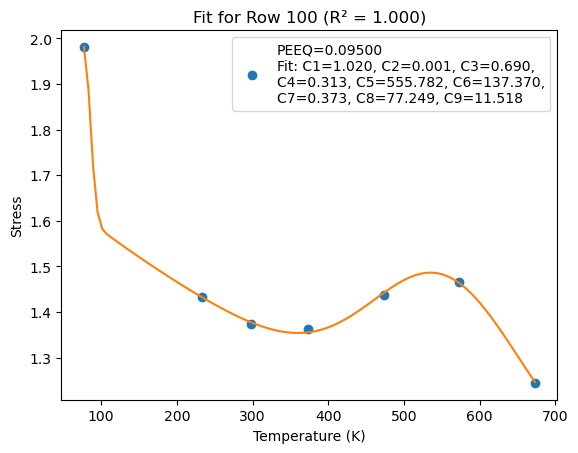

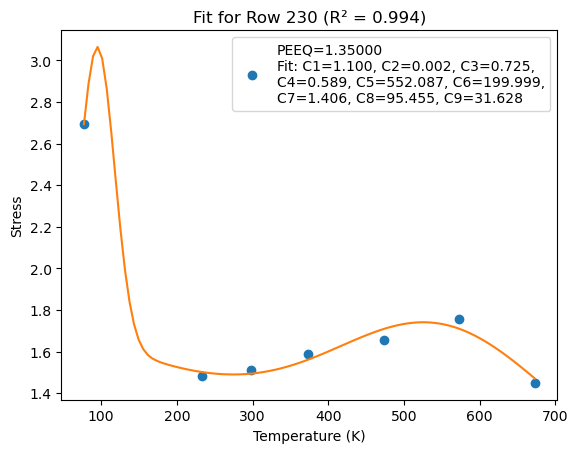

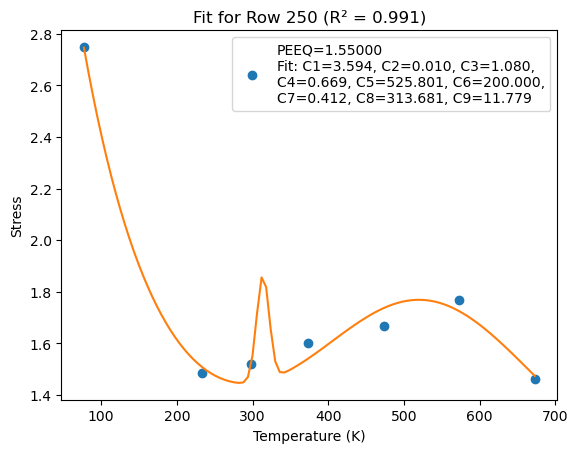

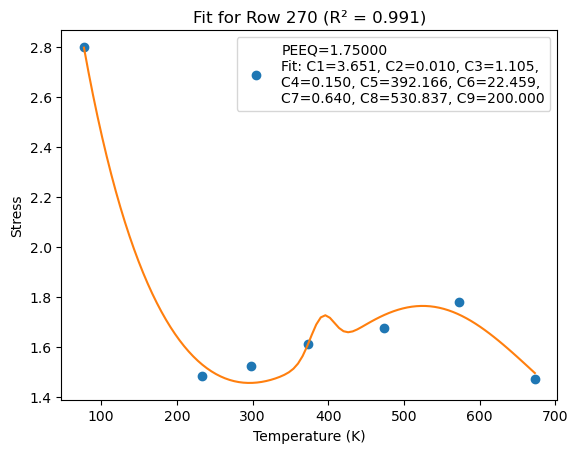

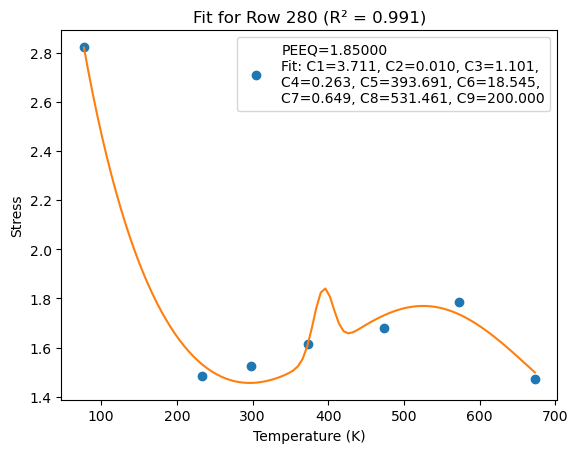

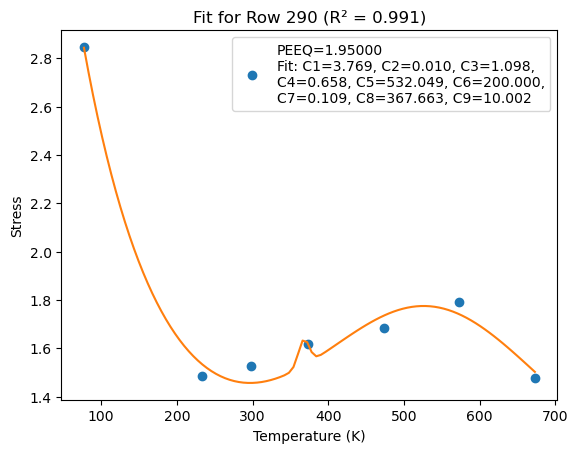

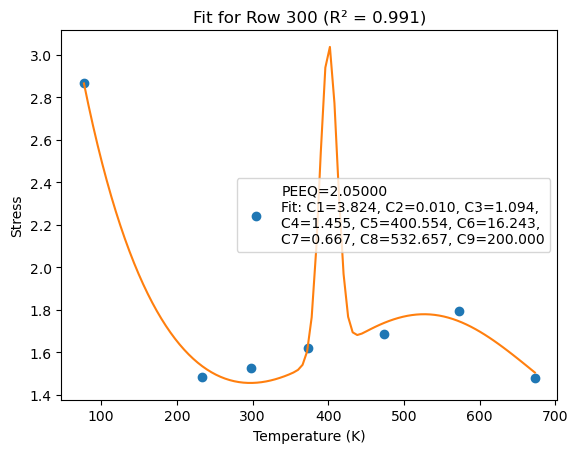

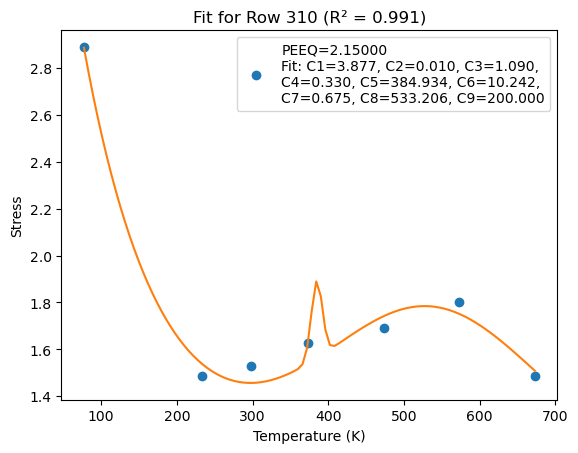

In [45]:
fit_data_with_9_parameters(file_0001, T, indices, starting_column)

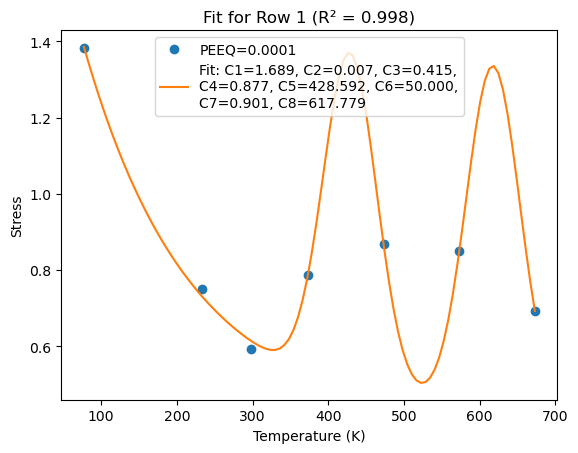

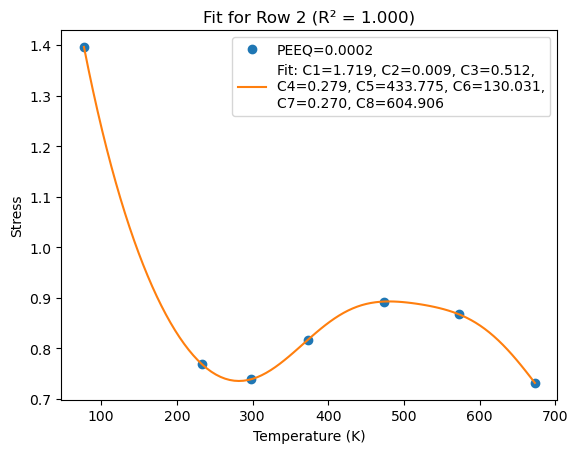

Could not fit row 3
Could not fit row 4
Could not fit row 5


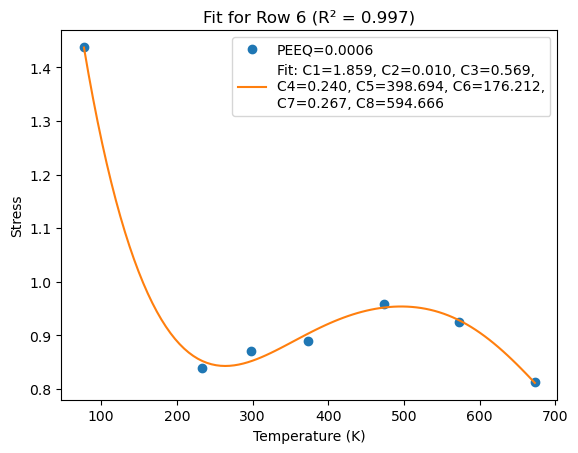

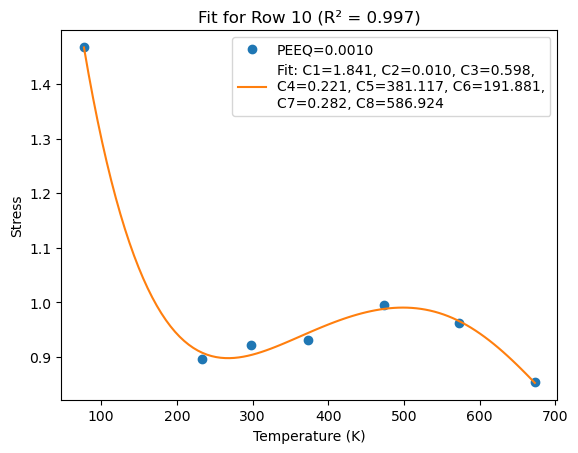

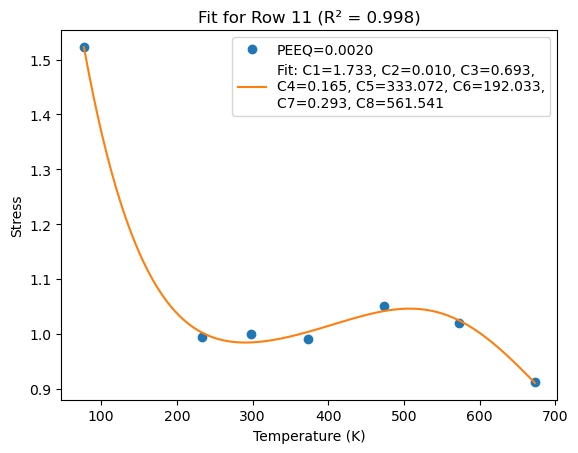

Could not fit row 14


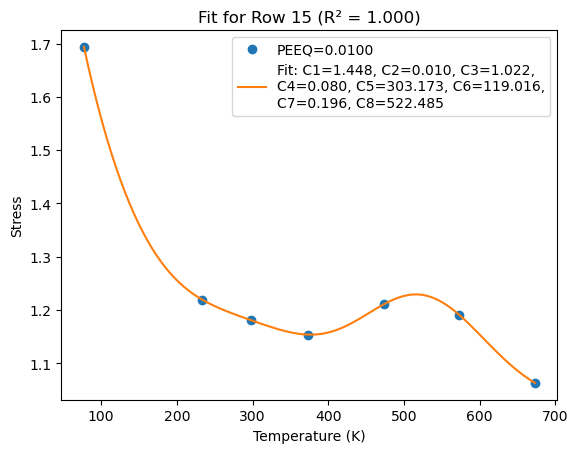

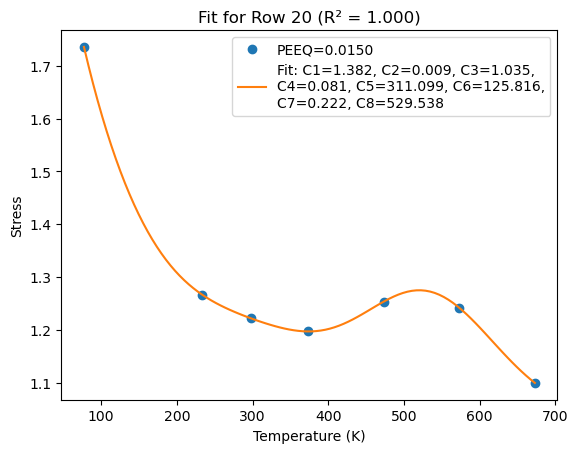

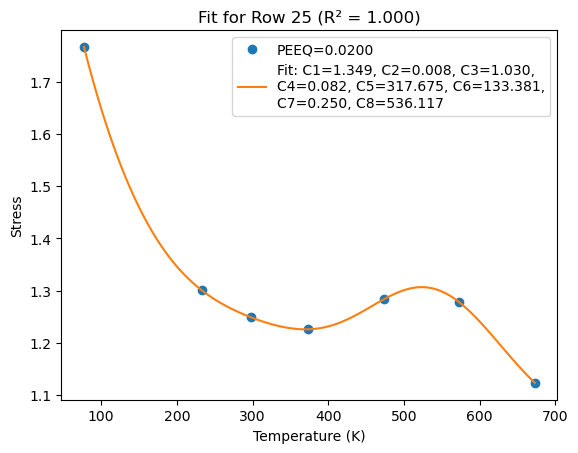

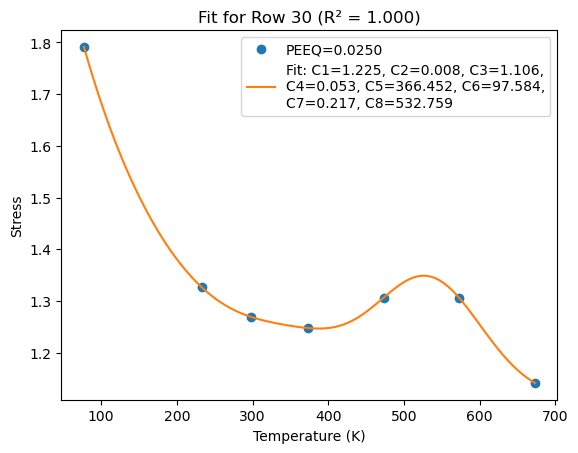

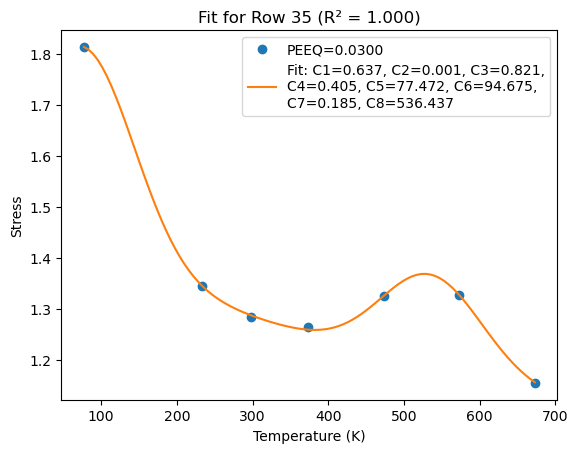

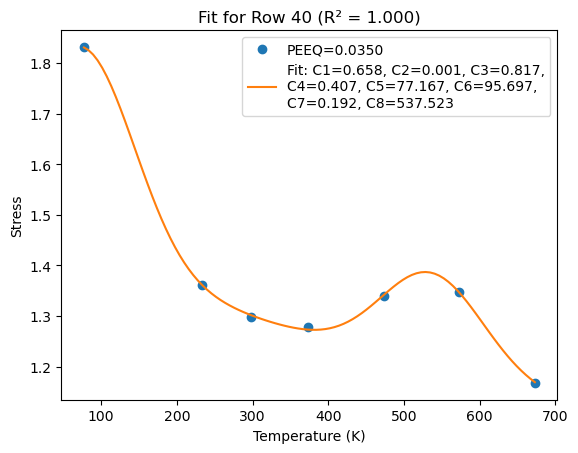

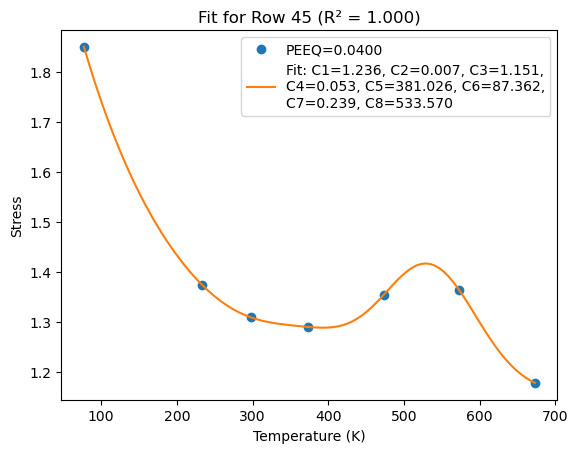

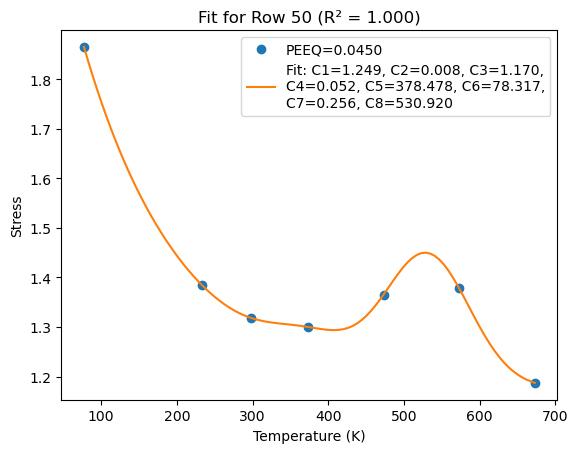

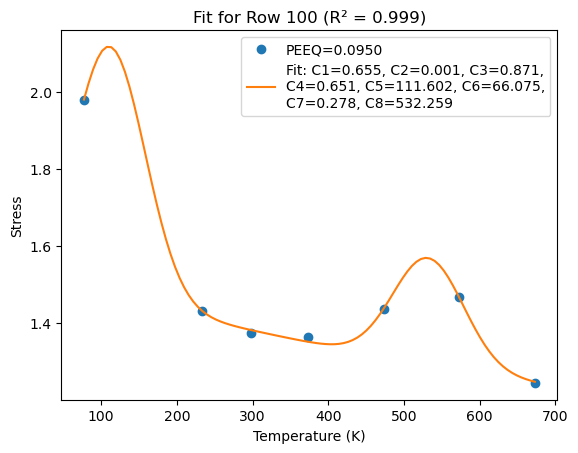

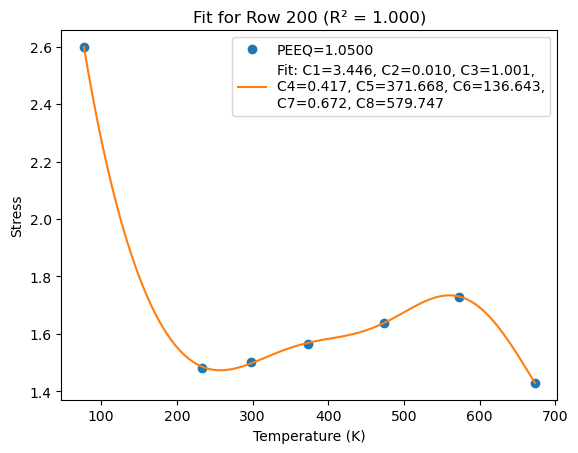

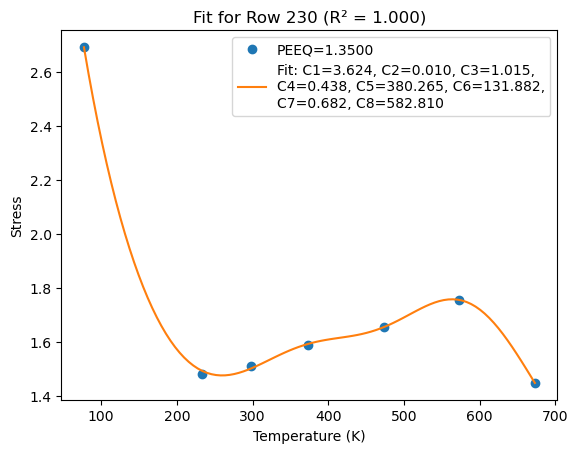

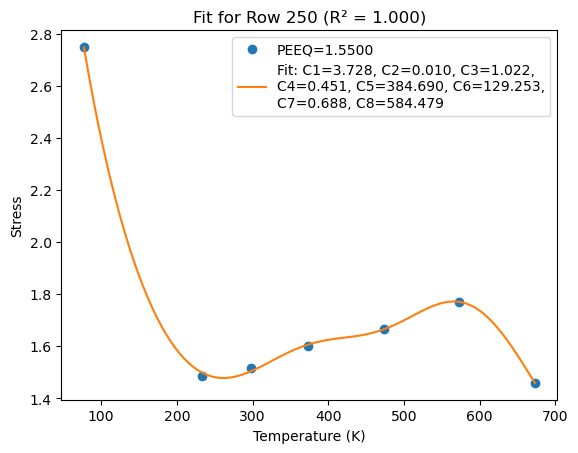

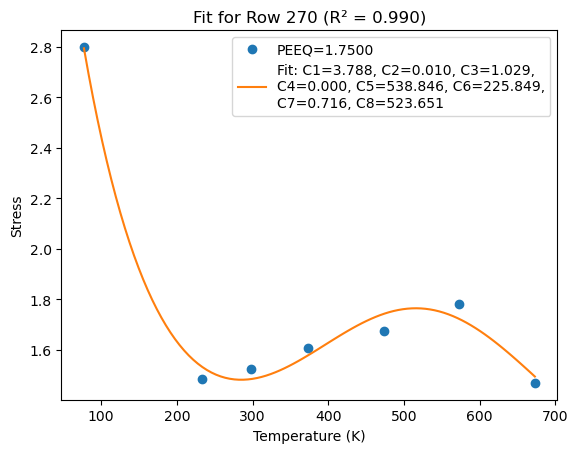

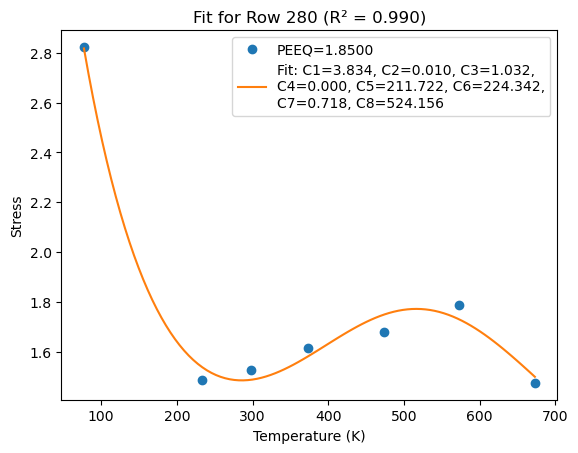

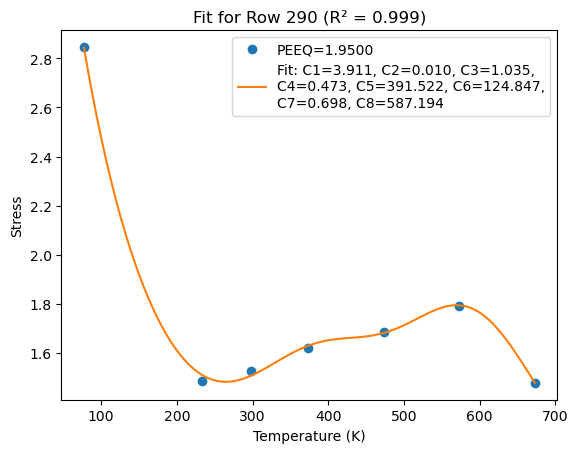

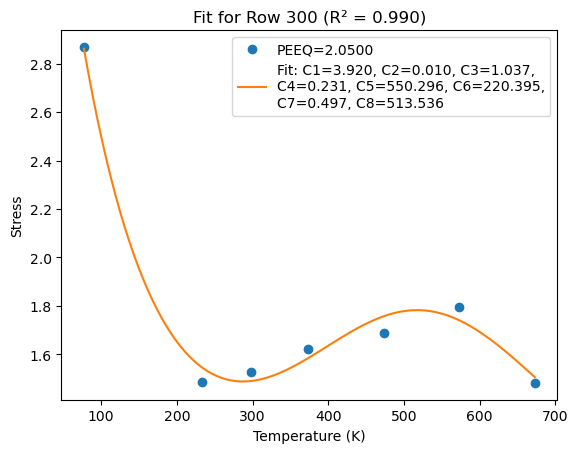

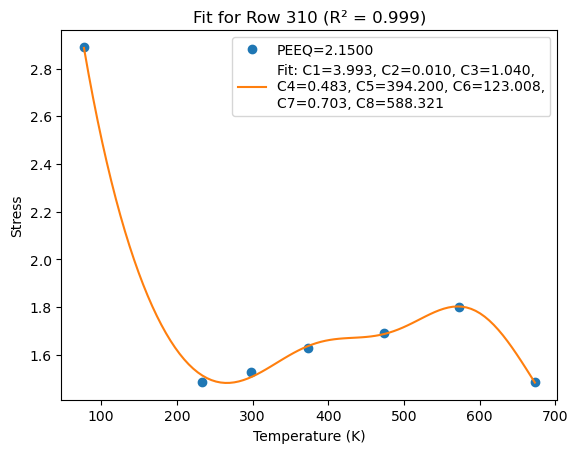

In [52]:
# Define the modified function to fit with an additional Gaussian term
def f_func(T, C1, C2, C3, C4, C5, C6, C7, C8):
    return (C1 * np.exp(-C2 * T) + 
            C3 + 
            C4 * np.exp(-((T - C5) / C6)**2) + 
            C7 * np.exp(-((T - C8) / C6)**2))

# Temperature data points
T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15])

# List of indices for the rows to process
indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])

# Dictionary to store fitted parameters
p = {}

# Loop through specified rows and perform fitting
for j, i in enumerate(indices):
    if i != 0:
        # Extract stress data from row `i`, starting from the 9th column to the end
        stress = data.iloc[i, 8:].values
        
        # Provide initial guesses and bounds for the new function with two Gaussian terms
        initial_guess = [1.5, 0.002, np.mean(stress), 1.0, np.mean(T), 100, 0.5, np.mean(T) + 100]
        bounds = (
            [0, 0.00001, np.min(stress) * 0.7, 0, np.min(T), 50, 0, np.min(T) + 50],  # Lower bounds
            [np.max(stress) * 2, 0.01, np.max(stress), 5, np.max(T), 300, np.max(stress), np.max(T)]  # Upper bounds
        )
        
        # Perform the curve fitting
        try:
            params, _ = curve_fit(f_func, T, stress, p0=initial_guess, bounds=bounds, max_nfev=20000)
        except RuntimeError:
            print(f"Could not fit row {i}")
            continue
        
        # Store the fitted parameters for this row
        p[f"fit{i}"] = params
        
        # Generate data for the fit curve
        T_fit = np.linspace(np.min(T), np.max(T), 100)
        stress_fit = f_func(T_fit, *params)
        
        # Calculate residuals for error estimation
        residuals = stress - f_func(T, *params)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((stress - np.mean(stress))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        if r_squared < 0.9:
            print(f'r_squared < 0.9 at PEEQ = {data.iloc[i, 0]:.5f}')
        
        # Plot the original data and the fitted curve
        plt.plot(T, stress, 'o', label='Data')
        plt.plot(T_fit, stress_fit, '-', label='Fit')
        plt.xlabel('Temperature (K)')
        plt.ylabel('Stress')
        plt.title(f"Fit for Row {i} (R² = {r_squared:.3f})")
        plt.legend([
            f'PEEQ={data.iloc[i, 0]:.4f}', 
            f'Fit: C1={params[0]:.3f}, C2={params[1]:.3f}, C3={params[2]:.3f},\n'
            f'C4={params[3]:.3f}, C5={params[4]:.3f}, C6={params[5]:.3f},\n'
            f'C7={params[6]:.3f}, C8={params[7]:.3f}'
        ])
        plt.show()

7 parameter

In [86]:
def fit_data_with_7_parameters(file, T, indices, starting_column):
    data = pd.read_csv(f"{file}_ref.csv")
    csv_output_path = f'Parameters_7_{file}.csv'
    
    # Define the modified function with an additional exponential decay term
    def f_func(T, C1, C2, C3, C4, C5, C6, C7):
        return C1 * np.exp(-C2 * T) + C3 + C4 * np.exp(-((T - C5) / C6)**2) + C7 * np.exp(-0.001 * T)
    
    # Initialize a list to store fitted parameters for CSV
    fitted_parameters = []
    
    # Loop through specified rows and perform fitting
    for j, i in enumerate(indices):
        if i != 0:
            # Extract stress data from row `i`, starting from the specified starting column to the end
            stress = data.iloc[i, starting_column:].values

            # Adjusted bounds to allow more flexibility in fitting
            bounds = (
                [0, 0.00001, np.min(stress) * 0.1, 0, np.min(T), 10, 0],   # Lower bounds
                [np.max(stress) * 2, 0.01, np.max(stress), 10, np.max(T), 400, np.max(stress) * 0.5]  # Upper bounds
            )

            # Perform the curve fitting without an initial guess
            try:
                params, _ = curve_fit(f_func, T, stress, bounds=bounds, max_nfev=20000)
            except RuntimeError:
                print(f"Could not fit row {i}")
                continue

            # Collect the parameters for saving in the CSV file
            fitted_parameters.append([data.iloc[i, 0], *params])

            # Generate data for the fit curve
            T_fit = np.linspace(np.min(T), np.max(T), 100)
            stress_fit = f_func(T_fit, *params)

            # Calculate residuals for error estimation
            residuals = stress - f_func(T, *params)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((stress - np.mean(stress))**2)
            r_squared = 1 - (ss_res / ss_tot)

            # Plot the original data and the fitted curve
            plt.figure()
            plt.plot(T, stress, 'o', label='Data')
            plt.plot(T_fit, stress_fit, '-', label='Fit')
            plt.xlabel('Temperature (K)')
            plt.ylabel('Stress')
            plt.title(f"Fit for Row {i} (R² = {r_squared:.3f})")
            plt.legend([
                f'PEEQ={data.iloc[i, 0]:.5f}\n'
                f'Fit: C1={params[0]:.3f}, C2={params[1]:.3f}, C3={params[2]:.3f},\n'
                f'C4={params[3]:.3f}, C5={params[4]:.3f}, C6={params[5]:.3f}, C7={params[6]:.3f}'
            ])
            plt.show()

    # Save the parameters to a CSV file
    columns = ['PEEQ', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
    fitted_parameters_df = pd.DataFrame(fitted_parameters, columns=columns)
    fitted_parameters_df.to_csv(csv_output_path, index=False)
    print(f"Fitted parameters saved to '{csv_output_path}'")

In [87]:
file_0001 = 'Fitted_FC_TmpDpn_RD_StrRt0.01'
T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
#T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
#indices = np.arange(1, 306)
starting_column = 6 #other strain-rates
#starting_column = 8 #0.0001

/opt/software/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


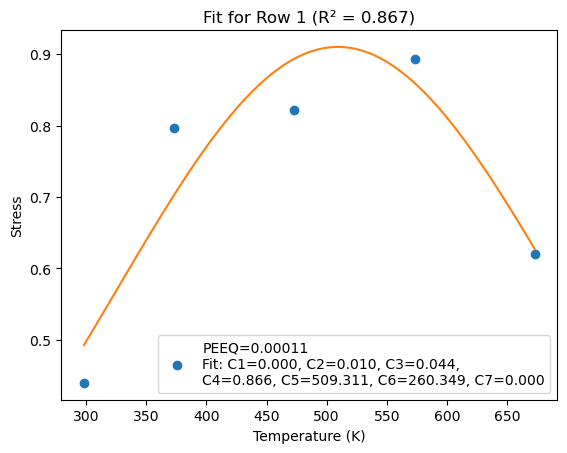

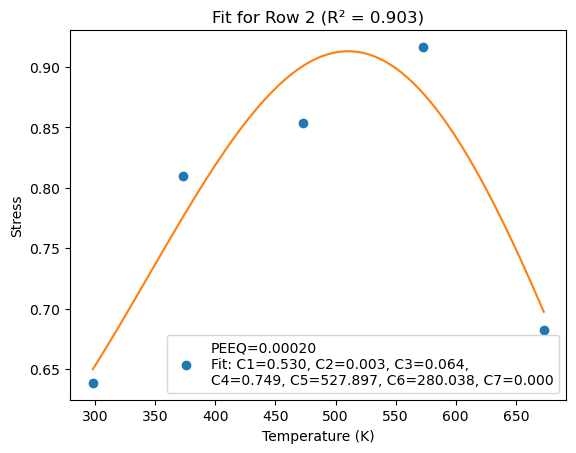

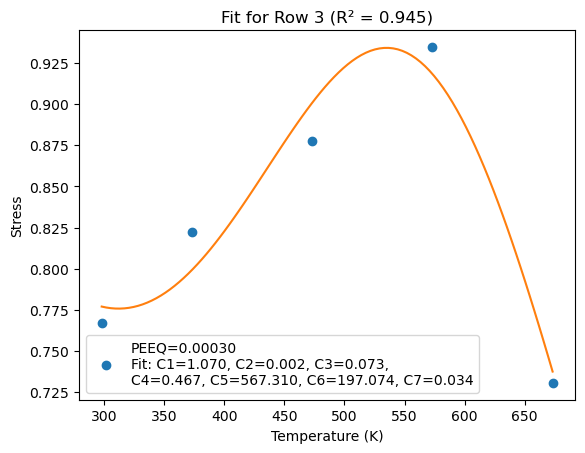

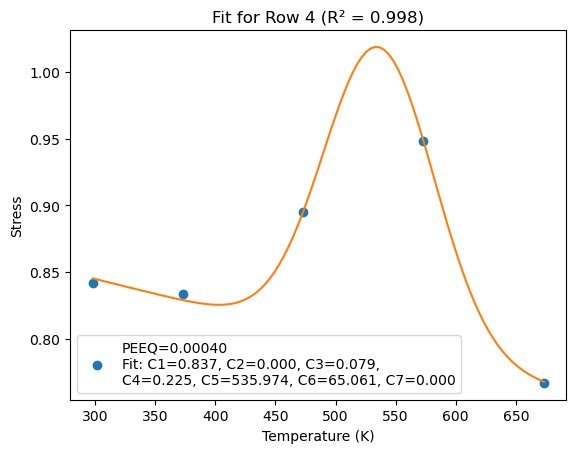

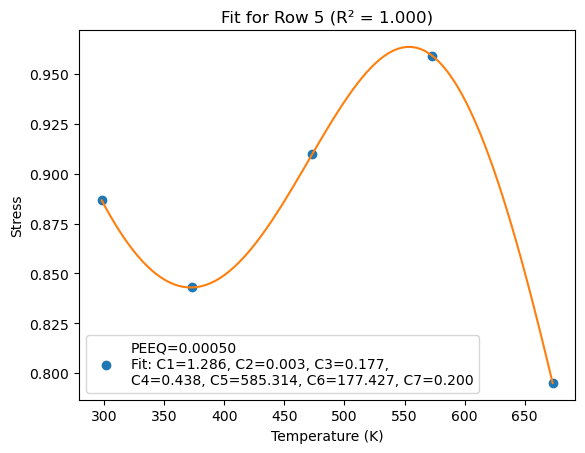

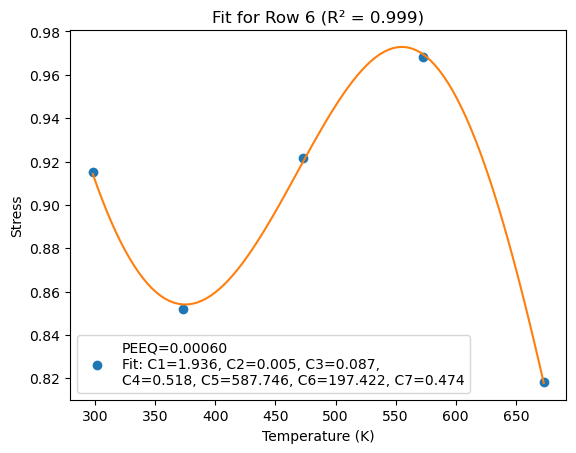

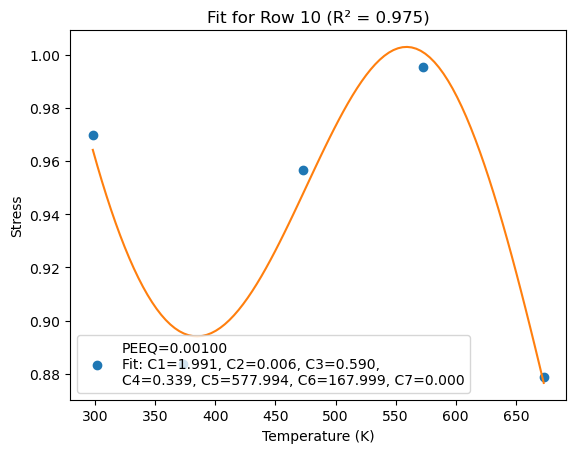

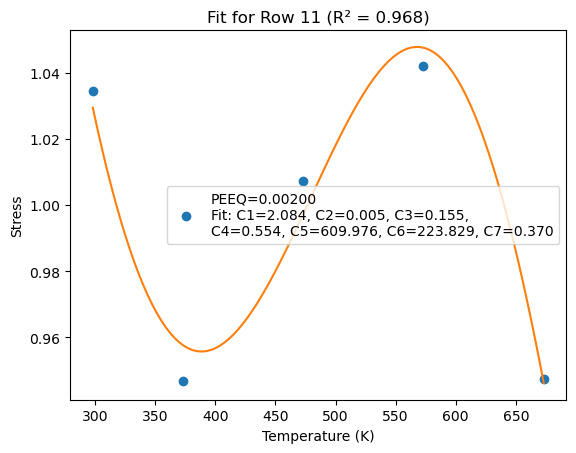

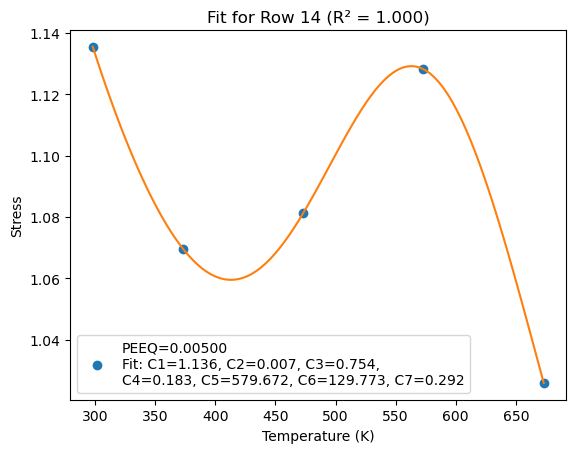

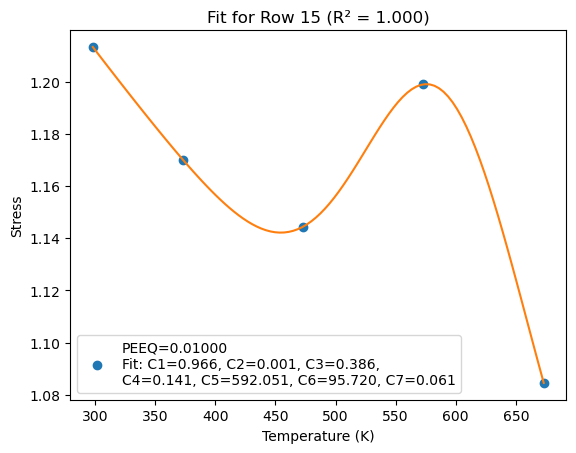

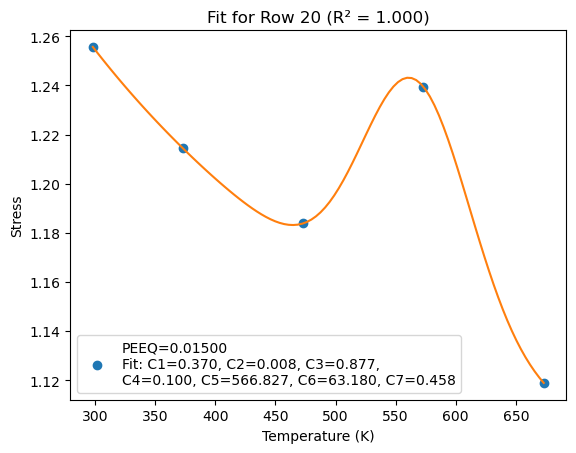

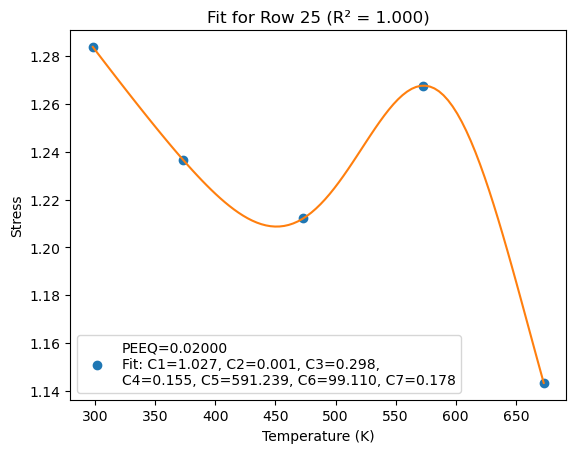

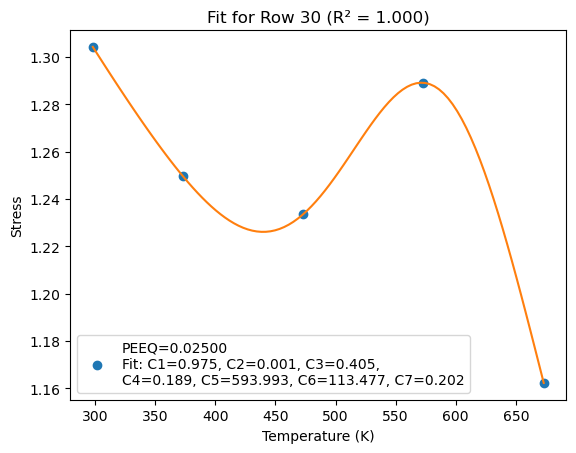

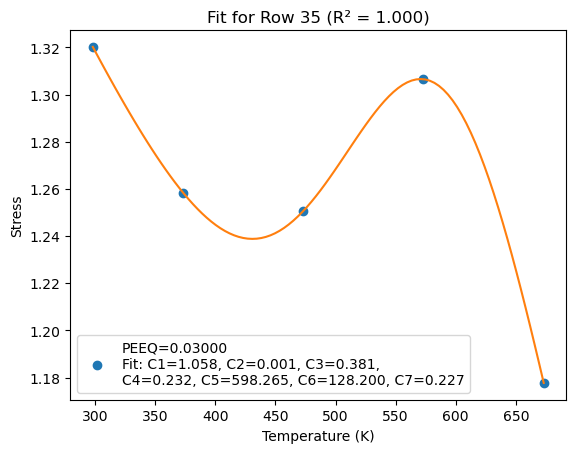

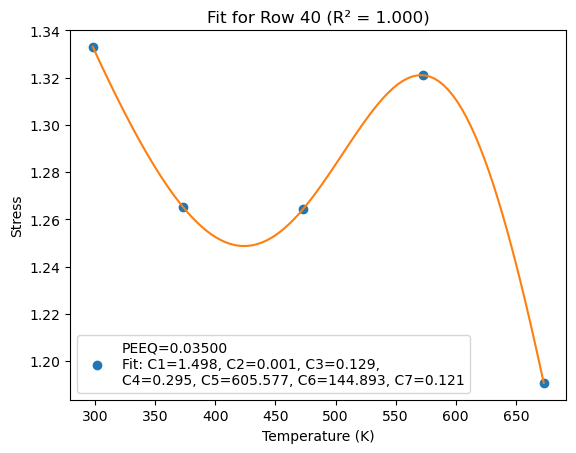

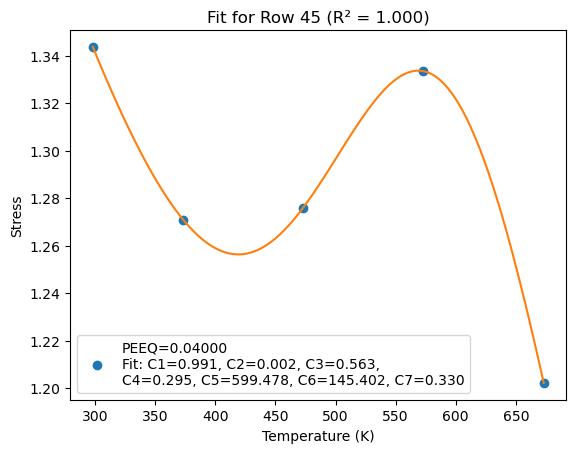

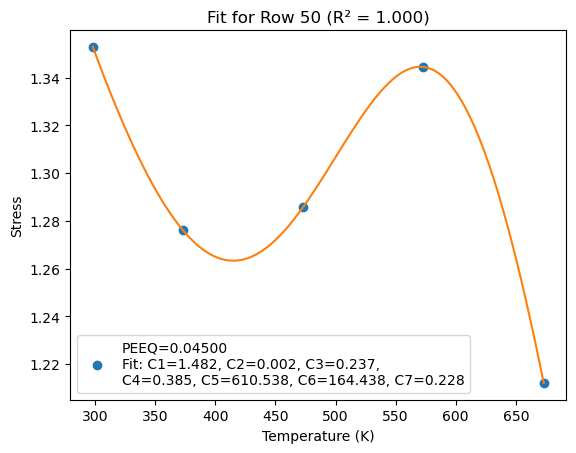

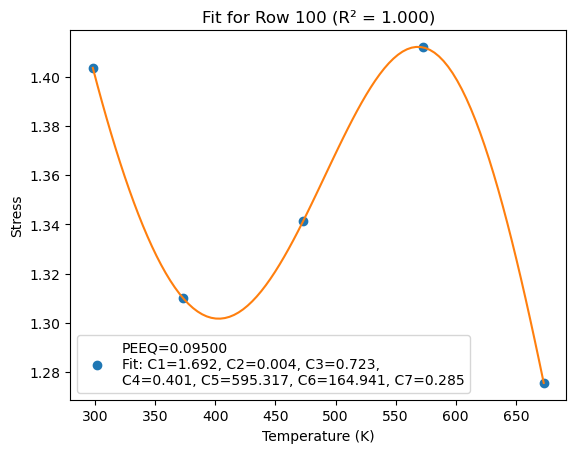

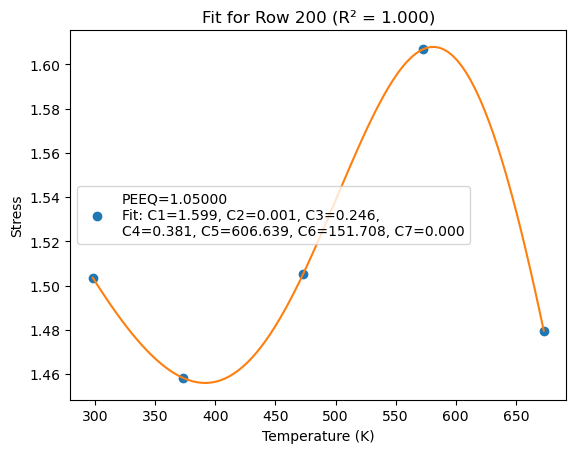

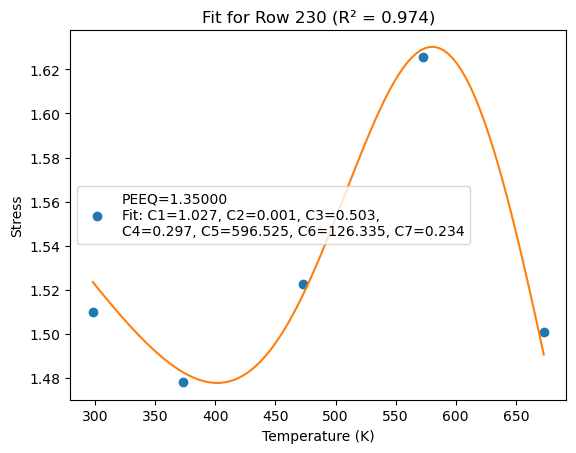

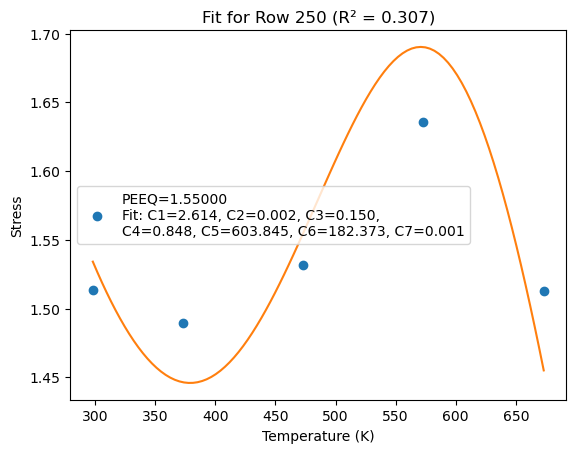

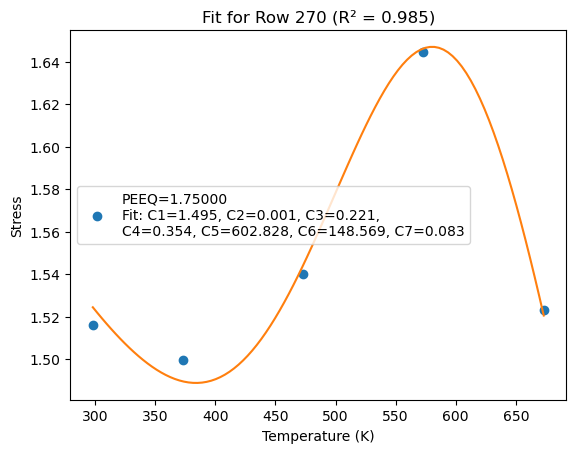

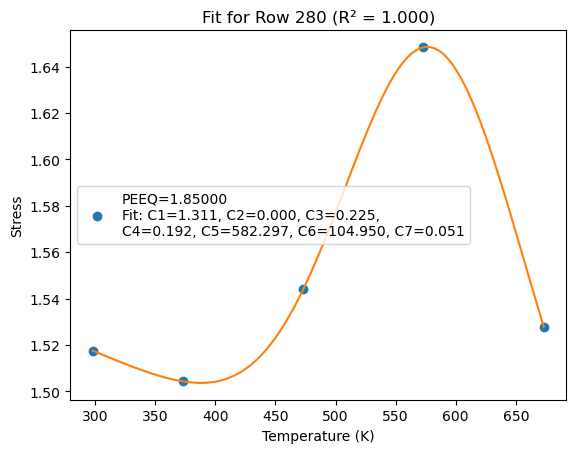

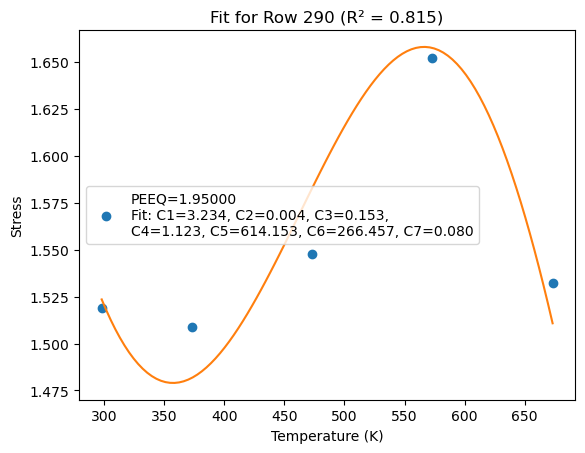

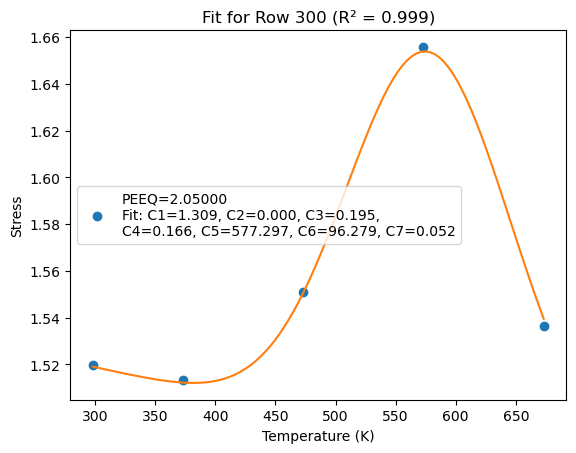

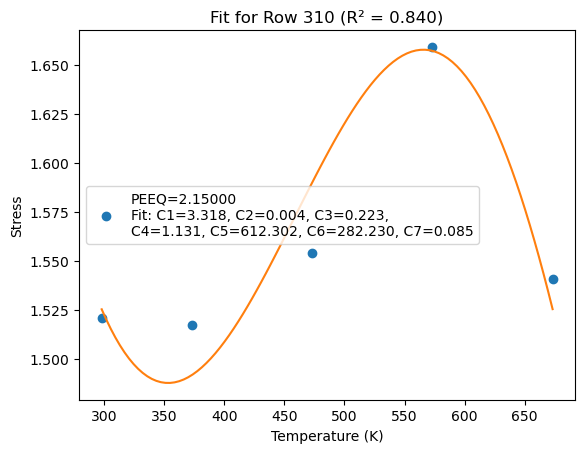

Fitted parameters saved to 'Parameters_7_Fitted_FC_TmpDpn_RD_StrRt0.01.csv'


In [88]:
fit_data_with_7_parameters(file_0001, T, indices, starting_column)

## Final

In [141]:
def fit_data_with_6_parameters(file, T, indices, starting_column):
    data = pd.read_csv(f"{file}_ref.csv")
    csv_output_path = f'Parameters_6_{file}.csv'
    output_pdf = f"{file}.pdf"
    # Define the function to fit with six parameters
    def f_func(T, C1, C2, C3, C4, C5, C6):
        return C1 * np.exp(-C2 * T) + C3 + C4 * np.exp(-((T - C5) / C6)**2)
    
    # Initialize a list to store fitted parameters for CSV
    fitted_parameters = []
    pdf_pages = PdfPages(output_pdf)
    
    for j, i in enumerate(indices):
        if i != 0:
        # Extract stress data from row `i`, starting from the 9th column to the end
            stress = data.iloc[i, starting_column:].values
        
        # Provide initial guesses and bounds
        #initial_guess = [1, 0.001, 0.5, 1, 300, 100]
        #bounds = ([0, 0.0001, 0, 0, 0, 100], [5., 0.003, 3.0, 10, 600, 500])
        #initial_guess = [1, 0.002, np.mean(stress), 1.0, np.mean(T), 100]
        #bounds = (
                #[0, 0.00001, np.min(stress) * 0.7, 0, np.min(T), 50],  # Lower bounds for six parameters
                #[np.max(stress) * 2, 0.01, np.max(stress), 5, np.max(T), 300]  # Upper bounds for six parameters
           # )
            #initial_guess = [1.0, 0.005, np.mean(stress), 0.8, np.mean(T), 120]
            #initial_guess = [1.0, 0.001, np.mean(stress), 0.8, np.mean(T), 120]
            #initial_guess = [1.0, 0.001, np.mean(stress), 0.8, np.mean(T), 120]
            initial_guess = [1.0, 0.00001, np.mean(stress), 0.8, np.mean(T), 120]
            bounds = (
                [0, 0.000001, np.min(stress) * 0.1, 0, np.min(T)* 0.1, 50],  # Lower bounds
                [np.max(stress) * 3, 0.01, np.max(stress), 5, np.max(T), 300]  # Upper bounds
            )
        
        # Perform the curve fitting
            try:
                params, _ = curve_fit(f_func, T, stress, p0=initial_guess, bounds=bounds, max_nfev=10000)
            except RuntimeError:
                print(f"Could not fit row {i}")
                continue

            # Collect the parameters for saving in the CSV file
            fitted_parameters.append([data.iloc[i, 0], *params])

            # Generate data for the fit curve
            T_fit = np.linspace(np.min(T), np.max(T), 100)
            stress_fit = f_func(T_fit, *params)

            # Calculate residuals for error estimation
            residuals = stress - f_func(T, *params)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((stress - np.mean(stress))**2)
            r_squared = 1 - (ss_res / ss_tot)

            # Plot the original data and the fitted curve
            plt.figure()
            plt.plot(T, stress, 'o', label='Data')
            plt.plot(T_fit, stress_fit, '-', label='Fit')
            plt.xlabel('Temperature (K)')
            plt.ylabel('Stress')
            plt.title(f"Fit for Row {i} (R² = {r_squared:.3f})")
            plt.legend([
                f'PEEQ={data.iloc[i, 0]:.5f}\n'
                f'Fit: C1={params[0]:.3f}, C2={params[1]:.3f}, C3={params[2]:.3f},\n'
                f'C4={params[3]:.3f}, C5={params[4]:.3f}, C6={params[5]:.3f}'
            ])
           
            # Save the current figure to the PDF
            pdf_pages.savefig()
            plt.close()

    # Close the PDF file
    pdf_pages.close()

    # Save the parameters to a CSV file
    columns = ['PEEQ', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
    fitted_parameters_df = pd.DataFrame(fitted_parameters, columns=columns)
    fitted_parameters_df.to_csv(csv_output_path, index=False)
    print(f"Modified plots saved as '{output_pdf}'")
    print(f"Fitted parameters saved to '{csv_output_path}'")
       
    

In [119]:
file_0001 = 'Fitted_FC_TmpDpn_RD_StrRt0.01'
T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
#T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
indices = np.arange(1, 306)
starting_column = 6 #other strain-rates
#starting_column = 8 #0.0001
fit_data_with_6_parameters(file_0001, T, indices, starting_column)

/opt/software/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Modified plots saved as 'Fitted_FC_TmpDpn_RD_StrRt0.01.pdf'
Fitted parameters saved to 'Parameters_6_Fitted_FC_TmpDpn_RD_StrRt0.01.csv'


In [121]:
file_0001 = 'Fitted_FC_TmpDpn_RD_StrRt0.01'
T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
#T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
indices = np.arange(1, 306)
starting_column = 6 #other strain-rates
#starting_column = 8 #0.0001
fit_data_with_6_parameters(file_0001, T, indices, starting_column)

/opt/software/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Modified plots saved as 'Fitted_FC_TmpDpn_RD_StrRt0.01.pdf'
Fitted parameters saved to 'Parameters_6_Fitted_FC_TmpDpn_RD_StrRt0.01.csv'


In [123]:
file_0001 = 'Fitted_FC_TmpDpn_RD_StrRt0.01'
T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
#T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
indices = np.arange(1, 306)
starting_column = 6 #other strain-rates
#starting_column = 8 #0.0001
fit_data_with_6_parameters(file_0001, T, indices, starting_column)

/opt/software/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Modified plots saved as 'Fitted_FC_TmpDpn_RD_StrRt0.01.pdf'
Fitted parameters saved to 'Parameters_6_Fitted_FC_TmpDpn_RD_StrRt0.01.csv'


In [125]:
file_0001 = 'Fitted_FC_TmpDpn_RD_StrRt0.01'
T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
#T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
indices = np.arange(1, 306)
starting_column = 6 #other strain-rates
#starting_column = 8 #0.0001
fit_data_with_6_parameters(file_0001, T, indices, starting_column)

/opt/software/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Modified plots saved as 'Fitted_FC_TmpDpn_RD_StrRt0.01.pdf'
Fitted parameters saved to 'Parameters_6_Fitted_FC_TmpDpn_RD_StrRt0.01.csv'


In [142]:
file_0001 = 'Fitted_FC_TmpDpn_RD_StrRt0.01'
T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
#T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
indices = np.arange(1, 306)
starting_column = 6 #other strain-rates
#starting_column = 8 #0.0001
fit_data_with_6_parameters(file_0001, T, indices, starting_column)

/opt/software/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Modified plots saved as 'Fitted_FC_TmpDpn_RD_StrRt0.01.pdf'
Fitted parameters saved to 'Parameters_6_Fitted_FC_TmpDpn_RD_StrRt0.01.csv'


In [143]:
file_0001 = 'Fitted_FC_TmpDpn_RD_StrRt0.1'
T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
#T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
indices = np.arange(1, 306)
starting_column = 6 #other strain-rates
#starting_column = 8 #0.0001
fit_data_with_6_parameters(file_0001, T, indices, starting_column)

/opt/software/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Modified plots saved as 'Fitted_FC_TmpDpn_RD_StrRt0.1.pdf'
Fitted parameters saved to 'Parameters_6_Fitted_FC_TmpDpn_RD_StrRt0.1.csv'


In [144]:
file_0001 = 'Fitted_FC_TmpDpn_RD_StrRt0.0001'
#T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
indices = np.arange(1, 306)
#starting_column = 6 #other strain-rates
starting_column = 8 #0.0001
fit_data_with_6_parameters(file_0001, T, indices, starting_column)

/opt/software/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Modified plots saved as 'Fitted_FC_TmpDpn_RD_StrRt0.001.pdf'
Fitted parameters saved to 'Parameters_6_Fitted_FC_TmpDpn_RD_StrRt0.001.csv'


In [145]:
file_0001 = 'Fitted_FC_TmpDpn_RD_StrRt0.0001'
#T = np.array([298.15, 373.15, 473.15, 573.15, 673.15]) #other strain-rates
T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15]) #0.0001
indices = np.array([1,2,3, 4, 5, 6, 10,11,14,15,20,25,30,35,40,45,50,100,200,230,250,270,280,290,300,310])
indices = np.arange(1, 306)
#starting_column = 6 #other strain-rates
starting_column = 8 #0.0001
fit_data_with_6_parameters(file_0001, T, indices, starting_column)

Modified plots saved as 'Fitted_FC_TmpDpn_RD_StrRt0.0001.pdf'
Fitted parameters saved to 'Parameters_6_Fitted_FC_TmpDpn_RD_StrRt0.0001.csv'
